In [3]:
'''
Cumulative test of RouteMap, BusModel, and TripDynamics.
'''

'\nCumulative test of RouteMap, BusModel, and TripDynamics.\n'

In [1]:
# General Imports
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Package Imports
import RouteMap as rm
import BusModel as bm
import TripDynamics as td
import Helper_Methods as hm

In [3]:
# Import the relevant area data:
# All Transit Stops:
stops_path = "./Data/Transit_Stops/Transit_Stops_for_King_County_Metro__transitstop_point.shp"
stops = gpd.read_file(stops_path)

# All signal lights:
signals_path = "./Data/Signals/KCM_Signals.shp"
signals = gpd.read_file(signals_path)

# All Streets:
seattle_streets_data ="./Data/Seattle_Streets/KCM_Streets.shp"
seattle_streets = gpd.read_file(seattle_streets_data)

In [4]:
# make a duplicate of the stops
all_stops = stops.copy()

# make a series of the signal geometry
all_signals = signals['geometry'].reset_index(drop=True)

# get the speed limits of all streets in the dataset
limits = seattle_streets[['geometry', 'SPEED_LIM']]

In [5]:
# set the route number, number of samples of points
# and time period of interest
route = 22
concat_val = 6
period = 'AM'

# Import the route data
route_path = "./Data/Routes/Individual_Routes/rt{}_pts.shp".format(route)
route_raw = gpd.read_file(route_path)

# filter to the resolution of the concat value
route_concat = route_raw[::concat_val]
route_concat = route_concat.reset_index(drop=True)

# get a series of the geometry and elevation from the data
route_geometry = route_concat['geometry']
route_elevation = route_concat['Z']

# using the helper method get_stops, find all stops the route intersects with.
route_stops = hm.get_stops(all_stops, str(route))['geometry'].reset_index(drop=True)

In [ ]:
# Generate a RouteMap with the RouteMap module, passing 
# the route geometry, elevation, limits, route_stops, 
# signals.
route_test_map = rm.RouteMap(route_geometry,
                             route_elevation,
                             limits,
                             route_stops,
                             all_signals,
                             debug = True)


#save the route_map as a csv for future, faster, use. 
route_test_map.get_gdf().to_csv('./Data/SAVED_ROUTEMAPS/route_map_{}.csv'.format(route))

In [6]:
# Load the RouteMap from the CSV
# First, generate a routemap from the geometry and elevation
route_test_map = rm.RouteMap(route_geometry, route_elevation)

# Add in the details from the saved CSV
#route_test_map = route_test_map.load_from_gdf('./Data/SAVED_ROUTEMAPS/route_map_{}.csv'.format(route))
route_test_map = route_test_map.load_from_gdf('./Data/Testing_materials/test_route_{}.csv'.format(route))

In [7]:
# Use in-built methods in RouteMap to get a smoothed elevation
# as a pandas series
smoothed_test_elevation = route_test_map.smooth_elevation()

# set the smoothed elevation as the route_test_map's elevation
smoothed_test_map = route_test_map.set_elevation(smoothed_test_elevation)


# convert distances using elevation to true distances traveled:
p_dist_elev = route_test_map.calc_travel_distances()
route_test_map = route_test_map.set_point_distances(p_dist_elev)

<Axes: >

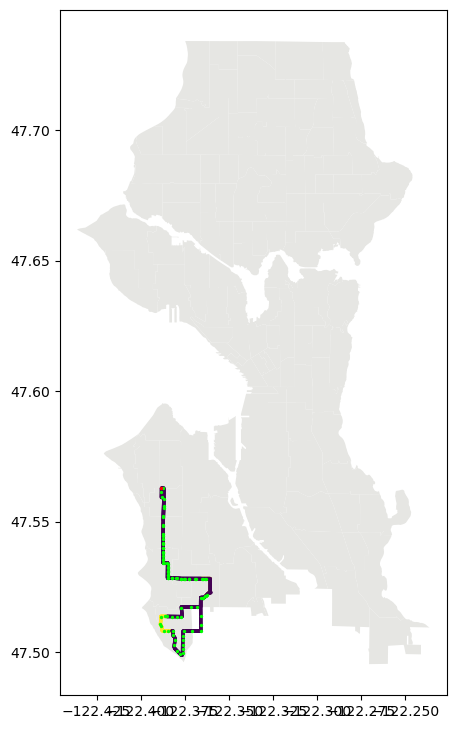

In [8]:
# Display a map of the route overlayed over area data:
# Import area map:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

# set up a figure:
fig, ax = plt.subplots(1, figsize = (5,10))

# Plot the map of the area:
seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)

# get the geodtaframe of the route_map
smooth_route_gdf = smoothed_test_map.get_gdf()

# plot the route by speed limit individually
smooth_route_gdf.plot(column='speed_limit[km/s]',
                      markersize=2,
                      ax=ax,
                      alpha=1,
                      zorder=10)


# plot the stops and signals
smooth_route_gdf[smooth_route_gdf['is_stop'] == True].plot(color='lime',
                                                           markersize=2,
                                                           ax=ax,
                                                           zorder=15)
smooth_route_gdf[smooth_route_gdf['is_signal'] == True].plot(color='red',
                                                             markersize=2,
                                                             ax=ax,
                                                             zorder=20)
                                                             


In [9]:
# Creating a bus model:
# Import an acceleration profile
acc_prof_path = "./Data/Accel_Prof/acceleration.csv"
raw_acc_prof = pd.read_csv(acc_prof_path, names=['time[s]', 'accel.[g]'])

# Make a duplicate to alter
a_prof = raw_acc_prof.copy()

# Convert g's to m/s^2 and then drop g's
a_prof['accel.[m/s^2]'] = a_prof['accel.[g]'] * 9.81
a_prof = a_prof.drop(columns = ['accel.[g]'])

# Create a default bus with the acceleration profile from above,
# otherwise using the default parameters
default_bus = bm.BusModel(a_prof)

In [10]:
# Creating a trip:
# Load the ridership data
ridership_path = "./Data/Trip_Data/Zon183Unsum.csv"
kcm_ridership = pd.read_csv(ridership_path)

# filter the ridership to the selected period and route
trip_ridership = kcm_ridership[(kcm_ridership['Route']==route) & (kcm_ridership['Period']==period)]
# sort the route_ridership so the stops are in proper order
sorted_riders = trip_ridership.sort_values(by=['InOut','Trip_ID', 'STOP_SEQ', 'STOP_ID'])
sorted_riders = sorted_riders[['InOut','STOP_SEQ', 'STOP_ID', 'AveOn', 'AveOff', 'AveLd']]
sorted_riders = sorted_riders.drop_duplicates(subset=['InOut','STOP_SEQ'], keep='first')
sorted_riders = sorted_riders.drop_duplicates(subset='STOP_ID', keep='first')
sorted_riders = sorted_riders.reset_index(drop = True)
sorted_riders['Index'] = sorted_riders.index

# get the mean ridership change at each stop
sorted_riders_diff = sorted_riders['AveOn'] - sorted_riders['AveOff']

#Export the rider difference to a csv for ease of editing and access
#sorted_riders_diff.to_csv('rider_diff_{}.csv'.format(route))
sorted_riders_diff = pd.read_csv('./Data/Testing_materials/test_diff_22.csv')['0']
#sorted_riders_diff = sorted_riders_diff[:len(smooth_route_gdf[smooth_route_gdf['is_stop'] == True])]

### busmodel adjustment section

In [70]:
import pandas as pd
import numpy as np

class BusModel:
    def __init__(self,
                 acceleration_profile, # two column dataframe containing time(s), accel(m/s^2)
                 raw_mass = 13041, # kilograms, New Flyer Xcelsior Charge []
                 bus_width = 2.6, # meters, New Flyer Xcelsior Charge []
                 bus_height = 3.3, # meters, New Flyer Xcelsior Charge []
                 drag_coeff = 0.6, # From Aggregate, Abdelaty & Mohamed []
                 factor = 1.1, # intertial factor, Asamer Et. Al []
                 fric_coeff = .01, # Abdelaty & Mohamed []
                 motor_eff = .916, # unknown source, not listed in paper -- tourque and speed depemdamt, next level would be based on tourqe
                 invert_eff = .971, # unknown source, not listed in paper
                 max_power = 160, # kW, output New Flyer Xcelsior Charge []
                 regen = .6, # Gallet et al []
                 eff_aux = .89, # unknown source, Auxulliary system efficiency?
                 aux_load = 7000, # W, Abdelaty & Mohamed []
                 a_braking = -1.5, #m/s^2 # https://www.apta.com/wp-content/uploads/APTA-BTS-BC-RP-001-05_Rev1.pdf <-- Possible source, handbrake road minimum is ~1.5
                 final_a = .4, # m/s^2, defualt acceleration after profile finishes
                 max_velocity = 26.8224, # m/s, = 60 mph
                 maintain_acceleration = False, # boolean for if bus should maintain the last a in 
                                                # profile or use final_a for extrapolating new vals
                 num_starting_passengers = 0,
                 pass_ave_mass = 80, #kg, Gallet et Al. []
                
                 ):
        # raw bus characteristics -- Not all of these are used, but may be useful for the future
        self._empty_mass = raw_mass
        self._bus_width = bus_width
        self._bus_height = bus_height
        self._bus_front_area = self._bus_width * self._bus_height
        self._drag_coeff = drag_coeff
        self._i_factor = factor
        self._fric_coeff = fric_coeff
        self._motor_eff = motor_eff
        self._invert_eff = invert_eff
        self._max_power = max_power
        self._regen = regen
        self._eff_aux = eff_aux
        self._aux_load = aux_load
        
        # driving model characteristics
        self._a_braking = a_braking
        self._final_a = final_a
        self._final_a_boolean = maintain_acceleration
        self._max_v = max_velocity
        self._accel_profile_df = self.interpret_accel_prof(acceleration_profile)
        
        # variables based on position in route
        self._passengers = num_starting_passengers
        self._mass_p_pass = pass_ave_mass
        self._current_velocity = 0
        self._current_accel = 0
        self._distance_traveled = 0
        self._bus_status = "Stopped"
        self._current_mass = self._empty_mass + self._passengers * self._mass_p_pass
        
        
    def interpret_accel_prof(self, accel_prof):
        """
        interpret_accel_prof is used to format the acceleration
        profile so as to have velocity and distance traveled.
        
        Parameters:
        accel_prof: dataframe of time and acceleration values,
                    in seconds and m/s^2.
        
        Returns: 
        dataframe of time, acceleration, velocity, and distance
        in seconds and meters units.
        """
        # Generate a copy of the profile
        acc_prof = accel_prof.copy()
        
        # Get the changes in time
        acc_prof['dt'] = acc_prof['time[s]'].diff()
        
        # use mean_integral to get the velocity data
        acc_prof['vel.[m/s]'] = self.mean_integral(acc_prof['dt'], acc_prof['accel.[m/s^2]'])
        
        # use mean_integral to get the distance data
        acc_prof['dist.[m]'] = self.mean_integral(acc_prof['dt'], acc_prof['vel.[m/s]'])
        
        while (not (acc_prof['vel.[m/s]'].iloc[-1] >= self._max_v)):
            
            # Generate a new row dictionary from the columns
            new_row = dict.fromkeys(list(acc_prof.columns))
            
            # set the step time to be 1 second
            d_t = 1
            
            # calculate the next time point using the previous and dt
            next_time = acc_prof['time[s]'].iloc[-1] + d_t 
            
            # default to using the _final_a acceleration
            next_accel = self._final_a
            
            # if the parameters say to maintain acceleration,
            if self._final_a_boolean:
                # Keep the last acceleration
                next_accel = acc_prof['accel.[m/s^2]'].iloc[-1]
            
            # calculate the next velocity
            next_v = acc_prof['vel.[m/s]'].iloc[-1] + d_t*next_accel
            
            # calculate the next distance
            next_d = acc_prof['dist.[m]'].iloc[-1] + d_t * (next_v + acc_prof['vel.[m/s]'].iloc[-1]) / 2
            
            # generate the list of data
            data = [next_time, next_accel, d_t, next_v, next_d]
            
            # put the data into the dictionary
            for i in range(len(data)): new_row[list(new_row.keys())[i]] = data[i]
            
            # Append the new row on to the profile dataframe
            acc_prof.loc[len(acc_prof)] = new_row
            
        # drop the dt column
        #acc_prof = acc_prof.drop(columns = ['dt'])
        
        # return the acceleration profile dataframe
        return acc_prof
    
    
    def mean_integral(self, time_changes, value_series):
        """
        mean_integral takes in a series of dt (s) values, and
        a corresponding series of other values to be integrated
        with respect to time, and provides the result as a
        cumulative summing series. 

        Parameters:
        time_changes: a pandas series of dT values in units of seconds
        value_series: a pandas series of d[value] that has relation to time.

        Returns: 
        a pandas series of the integrated values.
        """
        int_prof = pd.DataFrame()
        int_prof['mean_val_btw'] = value_series.rolling(window=2).mean()
        int_prof['d[value]'] = int_prof['mean_val_btw'] * time_changes
        int_prof['integrated'] = int_prof['d[value]'].cumsum()

        return int_prof['integrated'].fillna(0)
    
    
    def get_braking_distance(self, velocity, braking_factor, ext_acc):
        '''
        get_braking_distance() takes in a velocity and the current external accelerations,
        and provides a calculation as to how far the bus would have to brake to reach a velocity of zero.
        
        Parameters:
        velocity: velocity, in m/s, the bus is travelling at
        ext_acc: the external accelerative force in m/s^2 the bus is experiencing.
        
        Returns:
        a distance, in meters, of how far the bus would have to brake to reach a velocity of zero.
        '''
        
        
        wind_accel = self.get_aerodynamic_drag(velocity, 0, 1.2)
        
        # Combine to get the net acceleration on the bus
        net_accel = -wind_accel - ext_acc
        a_bus = net_accel + self._a_braking*braking_factor*self._i_factor
        # Using the kinematics equation vf^2 = vi^2 + 2a(dX) to get
        # braking distance
        
        # ensure braking is not too harsh
        while (a_bus < self._a_braking):
            
            #add to the braking factor
            braking_factor -= .01
            
            # recalc the braking acceleration and bus acceleration
            braking_acc = self._a_braking*braking_factor*self._i_factor
            a_bus = net_accel + braking_acc
        
        # make sure that the braking factor is enough to actually slow the bus
        while (a_bus > -0.001 ) and (braking_factor <= 1):
            
            # Add to the braking factor
            braking_factor += .01
            
            # recalc the braking acceleration and bus acceleration
            braking_acc = self._a_braking*braking_factor*self._i_factor
            a_bus = net_accel + braking_acc
        
        dist = round((-velocity**2 / (2*(a_bus))), 5)
        
        # Check if the braking distance is not possible given the parameters
        if (dist < 0):
            dist = 2105 # Braking distance for mass of 25000, grade of -17 (seattle max), speed of 30 m/s, full brake
        return dist

    
    def get_aerodynamic_drag(self, bus_speed, wind_speed, air_density):
        '''
        get_aerodynamic_drag takes in wind speed and air density, and returns
        the acceleration, in m/s^2, they provide.
        
        Parameters:
        wind_speed: velocity, in m/s, of the wind.
        air_density: density, in kg/m^3, of the air.
        
        Returns:
        aerodynamic acceleration, in m/s^2.
        '''
        # Using the drag coefficient, bus frontal area, and passed parameters, calculate the acceleration of air due to drag
        air_drag = (self._drag_coeff * self._bus_front_area * (air_density/2) * (bus_speed - wind_speed)**2)/self._current_mass
        
        # Return said value.
        return air_drag # acceleration of air drag
    
    
    def get_inertial_acceleration(self):
        '''
        get_inertial_acceleration calculates the current acceleration of intertia the bus is undergoing.
        
        Parameters:
        N/A
        
        Returns:
        inertial acceleration of the bus, in Newtons.
        
        '''
        
        # Use the intertial factor, current mass, and current acceleration,
        # to get inertial acceleration.
        inertia = (self._i_factor * self._current_mass * self._current_accel) / self._current_mass
        return inertia # acceleration of inertia
    
    
    def update_riders(self, val, cat='change'):
        '''
        update riders takes in a value of how many riders get on (positive),
        or disembark (negative), and affects the bus mass and passenger count of the bus.
        
        Parameters:
        val: change in passengers as a float.
        cat: string, either 'change' or 'set', depending on if the number of passengers
             is being changed, or set. Default is 'change'.
        '''
        # Update passenger number, sum should never be < 0
        if (cat=='change'):
            self._passengers = self._passengers + val
        elif (cat == 'set'):
            self._passengers = val
        
        # Update total mass
        self._current_mass = self._empty_mass + self._passengers * self._mass_p_pass
        return None
    
    
    def brake_v3(self, dist, braking_factor, ext_acc):
        '''
        brake_v3() takes in a distance and braking factor and external acceleration,
        and determines the power and elapsed time for the bus to
        experience those conditions.
        
        Parameters:
        dist: distance to brake, in meters, as a float
        braking_factor: float representing how aggresive braking will be (max:1, min:0)
        ext_acc: the external acceleration, as a float, the bus
                 is experiencing due to gravity, friction, and elevation change.
        
        Returns:
        a touple containing the power [W] used and the elapsed time [s]. 
        '''

        # Get the current velocity and braking acceleration, 
        # using the factor to help determine how intense the braking is.
        v0 = self._current_velocity
        braking_acc = self._a_braking*braking_factor*self._i_factor

        # determine the external accelerations from intrinsic bus factors
        route_accel = ext_acc
        wind_accel = self.get_aerodynamic_drag(v0, 0, 1.2)

        # Generate the net acceleration the bus is experiencing, a_bus
        net_accel = (- wind_accel - route_accel)
        a_bus = net_accel + braking_acc
        
                # adjust braking to make sure it is less that .15 g's of acceleration
        while (a_bus < self._a_braking):
            braking_factor -= .01
            # recalc the braking acceleration and bus acceleration
            braking_acc = self._a_braking*braking_factor*self._i_factor
            a_bus = net_accel + braking_acc
        
        # make sure that the braking factor is enough to actually slow the bus
        while (a_bus > -0.001 ) and (braking_factor <= 1):
            
            # Add to the braking factor
            braking_factor += .01
            
            # recalc the braking acceleration and bus acceleration
            braking_acc = self._a_braking*braking_factor*self._i_factor
            
            a_bus = net_accel + braking_acc

            
        vf = 0
        # use kinematic equation to calculate final velocity,
        # Check to ensure calc is possible.
        if (v0**2 > np.abs(2*a_bus*dist)):
            vf = np.sqrt(v0**2 + 2*a_bus*dist)
            # if final velocity is slower than .1 m/s, set it to be zero
            if (vf < .1):
                vf = 0
        else:
            vf = 0


        #get the change in time from kinematics equations
        dt = ((vf - v0)/a_bus)

        # Calculate the power of the braking
        power_calc = braking_acc*self._current_mass*dist/dt


        #Set the velocity and acceleration of the bus.
        self._current_velocity = vf
        self._current_acceleration = a_bus

        # return the power and elapsed time.
        return power_calc, dt
    
    
    def generate_power_frame(self, dist, ext_a):
        '''
        generate_power_frame() takes in distance and external accelerations due to
        hills and friction, and generates an acceleration profile that is limited by max power.
        
        Parameters:
        dist: distance to travel, in meters
        ext_a: external acceleration due to hills/gravity and friction
        
        Returns:
        pandas dataframe of acceleration profile that is limited to travel distance and 
        maximum power. 
        '''
        # Get the raw acceleration profile and its length
        acc_prof = self.get_accel_profile().copy()
        profile_length = len(acc_prof)
        # get the current mass
        m = self._current_mass
        
        # rename acceleration column and time column
        acc_prof=acc_prof.rename(columns = {'accel.[m/s^2]':'true_accel'})
        acc_prof['t_i'] = acc_prof['time[s]']
        del(acc_prof['time[s]'])
        
        # Create change in time column
        acc_prof['t_f'] = acc_prof['t_i'].shift(-1)
        acc_prof['dt'] = (acc_prof['t_f'] - acc_prof['t_i']) 
        del(acc_prof['t_i'])
        del(acc_prof['t_f'])
        
        # create columns for initial velocity, power, and acceleration
        acc_prof['vi'] = 0
        acc_prof['power'] = 0
        acc_prof['a_param'] = 0
        
        # create varables for travel distance and iteratable for the while loop
        trav_dist = 0
        i = 0
                    
        # Calculate the maximum power    
        pmax = self._max_power * 1000
        # while the iteratable is less than the profile length,
        while (i<profile_length):
            # get the current true acceleration, change in time, and velocity
            tr_acc = acc_prof['true_accel'][i]
            dt = acc_prof['dt'][i]
            vi = acc_prof['vi'][i]
            
            # add the wind acceleration to the external accelerations:
            net_outside_a = ext_a + self.get_aerodynamic_drag(vi, 0, 1.2)
            
            # do a preliminary power calculation
            P = self.get_power(tr_acc, dt, vi, m, net_outside_a, self._i_factor)
            
            # Chack if the power exceeds the limit:
            if P > (pmax):
                # recalculate the maximum acceleration based on the power output maxing out
                tr_acc = self.get_max_accel(pmax, dt, vi, m, net_outside_a, self._i_factor)
                
                # recalculate the power based on the max acceleration
                P = self.get_power(tr_acc, dt, vi, m, net_outside_a, self._i_factor)
                
            # set the column varaibles to the adjustments
            vi += tr_acc * dt
            dx = vi*dt
            
            # adjust the travel distance
            trav_dist += dx

            # Set the next initial velocity to the current velocity
            acc_prof.at[i+1,'vi'] = vi
            
            # Set the true acceleration, power, change in time, and acceleration parameter
            acc_prof.at[i, 'true_accel'] = tr_acc
            acc_prof.at[i, 'power']= P
            acc_prof.at[i, 'dt'] = dt
            acc_prof.at[i, 'a_param'] = (net_outside_a)
            
            # iterate
            i+=1
            
        # drop the tail indicies of the dataframe, return the profile
        acc_prof.drop(acc_prof.tail(2).index,inplace=True)
        return acc_prof
    
    
    def get_power(self, a_true, dt, vi, m, a_out, i_factor):
        '''
        get_power calculates the power it takes to accelerate based on time,
        mass, external acceleration, initial velocity, and intertial factor.
        This probably should be a private method.
        '''
        P = m * (a_out + i_factor * a_true) * ((2 * vi + dt * a_true) / (2))
        return P


    def get_max_accel(self, pmax, dt, vi, m, a_out, i_factor):
        '''
        get_max_accel backcalculates from a maxumum power to the highest acceleration for those conditions.
        This probably should be a private method.
        '''
        sub1 = (4*(i_factor*dt)*((2*pmax/m) - 2*a_out*vi) + (-a_out * dt - 2*vi*i_factor)**2)
        num = (sub1)**(1/2) - (a_out * dt) - (2 * vi * i_factor)
        denom = 2 * i_factor * dt

        acc = num/denom

        if acc < 0:
            acc = -acc
    
        return acc
    
    
    def accelerate_v5(self, dist, ext_a):
        '''
        accelerate_v5() takes in distance traveled and the external 
        accelerational forces, and calculates the power needed to
        accelerate the bus for that distance, as well as the elapsed time.
        
        Parameters:
        dist: distance of travel in meters as a float.
        ext_acc: external accelerative force the bus is currently experiencing.
        
        Returns:
        a touple containing the power [W] used and the elapsed time [s]. 
        '''
        
        # Generate the acceleration profile for this set of conditions and the current state of the bus
        power_frame = self.generate_power_frame(dist, ext_a)
        
        # Get the length of the acceleration profile
        power_frame_len = len(power_frame)
        
        # Get the last velocity in the power frame as the maximum velocity
        profile_max = list(power_frame['vi'])[-1]
        
        # Get the bus current mass and velocity
        m = self._current_mass
        cur_v = self._current_velocity
        
        # Set up dummy variables to hold the travel distance, powers, and time changes
        trav_dist = 0
        p_list = []
        dt_list = []
        
        # set up an iteratable for the while loop.
        i=0
        
        # set up dimmy variables for p, dt, a, outside_a:
        p, dt, a, outside_a = None, None, None, None
        
        #while the distance to be traveled is less than the traveled distance
        while (dist > trav_dist):
            
            #Check if the velocity is less than the max velocity
            if (cur_v < profile_max):
                
                # if the current velocity is within the acceleration profile,
                # get the index of the closest velocity in the profile
                v_closest_index = list((power_frame['vi']-cur_v).abs().argsort())[0]
                
                # get the power, time, acceleration, and external acceleration for that entry
                p = power_frame['power'][v_closest_index]
                dt = power_frame['dt'][v_closest_index]
                a = power_frame['true_accel'][v_closest_index]
                outside_a = power_frame['a_param'][v_closest_index]
                
            # if the velocity profile is greater than the max velocity:
            else:
                
                # Get the last index of power, dt, and acceleration
                p = list(power_frame['power'])[-2]
                dt = list(power_frame['dt'])[-2]
                a = list(power_frame['true_accel'])[-1]
                
                # add the wind acceleration to the external acceleration
                outside_a = ext_a + self.get_aerodynamic_drag(cur_v, 0, 1.2)

            # Get the dx, dv
            dv = dt*a
            dx = cur_v*dt

            # Check if this would go over the distance
            if dx > abs(trav_dist - dist):

                # get the change in distance to the end of the segment
                dx = abs(trav_dist - dist)

                # get the new change in time
                dt = dx * (self._i_factor * a + outside_a) * m / p

                # calculate the new dv
                dv = a * dt 

            # adjust the current velocity and travel distance
            cur_v += dv
            trav_dist += dx

            #append the power and change in time
            p_list.append(p)
            dt_list.append(dt)
                
            # iterate by 1
            i+=1
        
        # covert to power, time, to series and sum the times
        pow_ser = pd.Series(p_list)
        tee_ser = pd.Series(dt_list)
        travel_time = tee_ser.sum()
        
        # calculate the mean power for the step
        mean_power = (pow_ser * tee_ser).sum() / travel_time
        
        self._current_velocity = cur_v
        
        #return the mean power, travel time
        return mean_power, travel_time
    
    
    def maintain_v5(self, dist, ext_acc):
        '''
        maintain_v5() takes in distance traveled and the external 
        accelerational forces, and calculates the power needed to
        maintain the current velocity and the elapsed time.
        
        Parameters:
        dist: distance of travel in meters as a float.
        ext_acc: external accelerative force the bus is currently experiencing.
        
        Returns:
        a touple containing the power [W] used and the elapsed time [s]. 
        '''
        # get the current velocity and mass
        v_i = self._current_velocity
        m = self._current_mass
        
        # Get the aero drag
        wind_a = self.get_aerodynamic_drag(v_i, 0, 1.2)
        
        # get the maximum power in watts
        max_p =  (self._max_power * 1000)
        
        # set up a dummy variable for net acceleration of the bus
        bus_a = 0
        
        # combine the external accelerations
        a_subsum = ext_acc + wind_a
        
        # Get the preliminary time change
        dt = dist/v_i
        
        # get the initial pass of final velocity
        v_f = v_i
        
        # first pass calculation of power
        power_calc = (self._i_factor * bus_a + a_subsum) * m * v_i
    
        # if the preliminary power calculation exceeds the maximum power
        if power_calc > max_p:
            
            # cycle until the power is matching the maximum power
            while power_calc > max_p:
                
                # decreace the bus' acceleration
                bus_a -= 10/max_p
                
                # recalculate time based on kinematic equations
                dt = ((2*bus_a*dist + v_i**2)**(1/2) - v_i) / bus_a 
                
                # get the new power calculation
                power_calc = self.get_power(bus_a, dt, v_i, m, a_subsum, self._i_factor)
        
        # adjust the current velocity according to the bus acceleration
        self._current_velocity = v_i + bus_a * dt
        
        return power_calc, dt
    
    
    # Getter methods, probably redundant and should turn into just public variables
    
    def get_accel_profile(self):
        return self._accel_profile_df
    
    def velocity(self):
        return self._current_velocity
    
    def set_v(self, v):
        self._current_velocity = v
    
    def max_velocity(self):
        return self._max_v
    
    def update_mass(self, val):
        self._current_mass = val
        return None
    
    def get_n_riders(self):
        return self._passengers
    
    def get_mass(self):
        return self._current_mass
    
    def get_acceleration(self):
        return self._current_accel
    
    def get_fric_coeff(self):
        return self._fric_coeff

    def get_b_accel(self):
        return self._a_braking
    
    def get_motor_eff(self):
        return self._motor_eff
    
    def get_invert_eff(self):
        return self._invert_eff
    
    def get_auxill_efficiency(self):
        return self._eff_aux
    
    def get_aux_load(self):
        return self._aux_load
    
    def get_regen_eff(self):
        return self._regen
        
    

### Evaluating efficacy of Braking methods
Here, I compare the bus's current braking methods (both for distance calculation, and for power and time calculation) to that of the ground truths. In so doing, I am also validating the wind speed calculation, should these prove identical.

In [71]:
# Set up a handful of parameters to iterate through when testing
mass_array = [10, 100, 1000, 10000, 25000] #5
velocity_array = [1, 2, 10, 20, 30] #6
grade_array = [-17, -9, 0, 9, 17] #7
braking_factors = [1, .8, .6, .4] #5

In [72]:
# Method for calculating braking distance from velocity, grade, braking factor, and mass
def braking_distance_formula(v_i, m, grade, braking_factor):
    a_fric = -(.01)*9.81*np.cos(np.arctan(grade/100))
    a_hill = -9.81*np.sin(np.arctan(grade/100))
    a_brake = 1.1*-1.5*braking_factor
    a_wind = -.6*8.58*1.2*(v_i**2)/(2*m)
    d = -(v_i**2)/2 * (1/(a_brake + a_wind + a_hill + a_fric))
    if (d < 0):
        d=2105 # Braking distance for mass of 25000, grade of -17 (seattle max), speed of 30 m/s, full brake
    return d

# Use same parameters as above but pass them into the bus model.
def bus_bd(v_i, m, grade, braking_factor):
    sample_bus = BusModel(a_prof, raw_mass = m)
    ext_a = (.01)*9.81*np.cos(np.arctan(grade/100)) + 9.81*np.sin(np.arctan(grade/100))
    sample_bus.set_v(v_i)
    return sample_bus.get_braking_distance(sample_bus.velocity(), braking_factor, ext_a)


# Generate the power calculation as it should be
def brake_power_calc(v_i, m, grade, braking_factor, dist):
    a_fric = (.01)*9.81*np.cos(np.arctan(grade/100))
    a_hill = 9.81*np.sin(np.arctan(grade/100))
    a_brake = 1.1*-1.5*braking_factor
    a_wind = .6*8.58*1.2*(v_i**2)/(2*m)
    
    vf=0
    if(v_i**2 > np.abs(2*(a_brake-a_wind-a_hill-a_fric)*dist)):
        vf =np.sqrt(v_i**2 + 2*(dist*(a_brake-a_wind-a_hill-a_fric)))
    dt = (vf-v_i )/(a_brake-a_wind-a_hill-a_fric)
    power = (a_brake)*m*dist/dt
    
    if (vf < .1):
        vf = 0
    return power, dt

# Evaluate the bus's current method of braking using the same variable inputs
def bus_brake_power(v_i, m, grade, braking_factor, dist):
    sample_bus = BusModel(a_prof, raw_mass = m)
    ext_a = (.01)*9.81*np.cos(np.arctan(grade/100)) + 9.81*np.sin(np.arctan(grade/100))
    sample_bus.set_v(v_i)
    return sample_bus.brake_v3(dist, braking_factor, ext_a)

In [73]:
# Check if the braking distances match for one set of parameters
braking_distance_formula(20, 10000, -17, 1)

884.3583678725018

In [74]:
# They do!
bus_bd(20, 10000, -17, 1)

884.35837

In [75]:
def pointwise_braking_test(grade, mass, b_factor, v_i, v_end, point_dist, plot=False):
    sample_bus = BusModel(a_prof, raw_mass = mass)
    sample_bus.set_v(v_i)
    ext_a = (.01)*9.81*np.cos(np.arctan(grade/100)) + 9.81*np.sin(np.arctan(grade/100))
    #print(9.81*np.sin(np.arctan(grade/100))/9.81)
    vees = [sample_bus.velocity()]
    pees = [0]
    tees = [0]
    dist = [0]
    i=0
    while (sample_bus.velocity()>v_end):
        i+=1
        p, t =sample_bus.brake_v3(point_dist, b_factor, ext_a)
        vees.append(sample_bus.velocity())
        #print((vees[i] - vees[i-1]) / (t*9.81))
        pees.append(p)
        tees.append(t + tees[i-1])
        dist.append(dist[i-1] + point_dist)
        
    if plot:
        fig, ax = plt.subplots(1, 3, figsize = (15, 5))
        ax[0].scatter(dist, vees)
        ax[1].scatter(dist, tees)
        ax[2].scatter(dist, pees)

        ax[0].set_xlabel('dist')
        ax[0].set_ylabel('vel')

        ax[1].set_xlabel('dist')
        ax[1].set_ylabel('t')

        ax[2].set_xlabel('dist')
        ax[2].set_ylabel('pow')
    
    print("{} G's of force".format(((v_i-v_end)/tees[-1])/9.81))

0.06459072730462485 G's of force


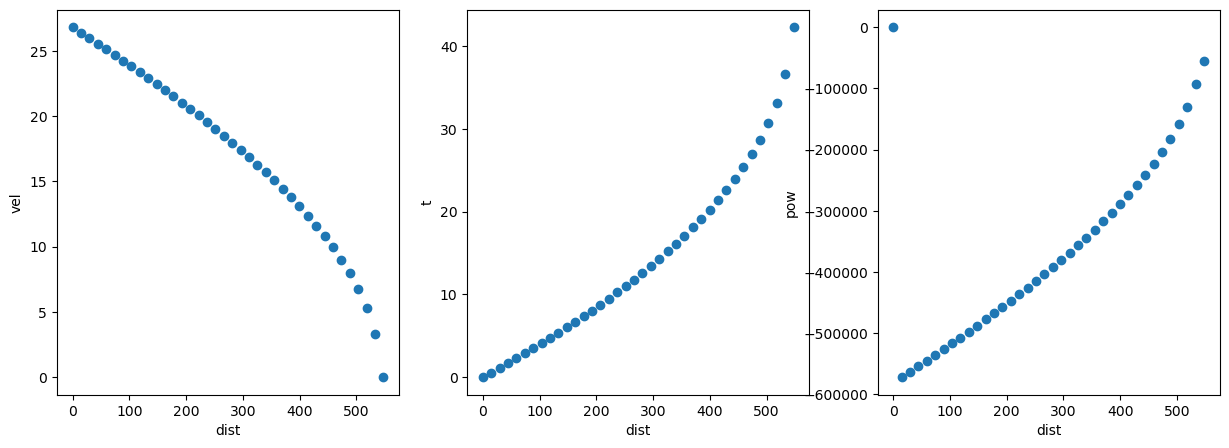

In [78]:
pointwise_braking_test(-12, 13041, 1, 26.8, 0, 14.8, True)

In [ ]:
i=0
for velocity in velocity_array:
    for grade in grade_array:
        for bf in braking_factors:
            pointwise_braking_test(grade, 130414, bf, velocity, 1)
            i+=1

In [260]:
# Iterate through each parameter and calculate the percent error between each measurement
    
data = []
for mass in mass_array:
    for velocity in velocity_array:
        for grade in grade_array:
            for bf in braking_factors: 
                dist = braking_distance_formula(velocity, mass, grade, bf)
                dist_bus = bus_bd(velocity, mass, grade, bf)
                diff = abs(dist_bus-dist) / dist
                bp, bt = brake_power_calc(velocity, mass, grade, bf, dist)
                bup, but = bus_brake_power(velocity, mass, grade, bf, dist_bus)
                dat_dict = {'power_bus': bup,
                            'power_true':bp,
                            'time_bus': but,
                            'time_true':bt,
                            'dist_bus': dist_bus,
                            'dist_true':dist,
                            'dist_diff': diff,
                            'pow_diff': abs(bup-bp)/bp,
                            't_diff':abs(but-bt)/bt,
                            'v':velocity,
                            'm': mass,
                            'grade':grade,
                            'br_fac':bf}
                
                data.append(dat_dict)
                
# Convert it to a dict.
results = pd.DataFrame(data)

Text(0, 0.5, 'time')

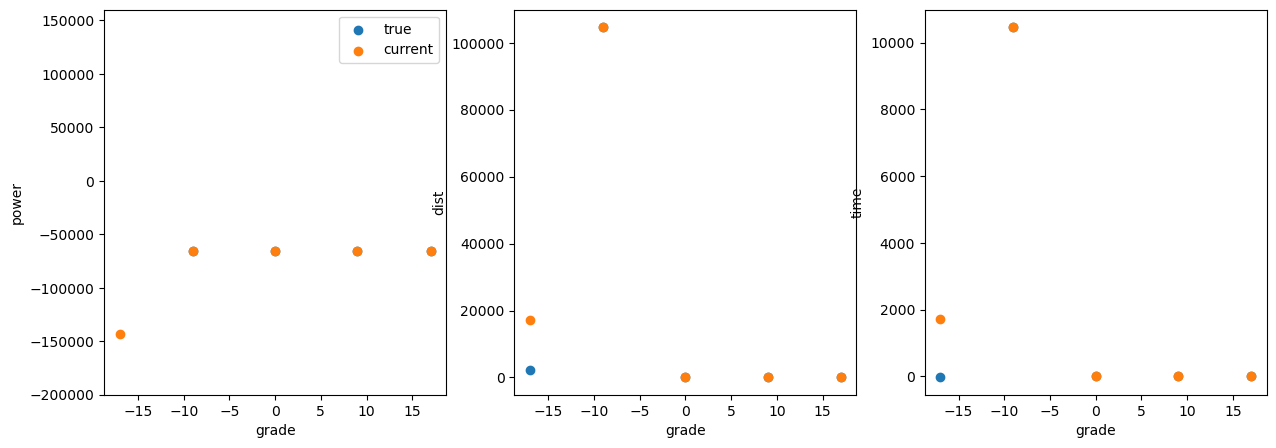

In [261]:
# Plot out the results for the braking methods. filter to a set mass, velocity, and braking factor.
mass_evaluation = 10000
velocity_eval = 20
braking_fac = .4
mass_results = (results[results['m'] == mass_evaluation])
mass_vel_results = mass_results[mass_results['v'] == velocity_eval]
mass_bf_vel_results = mass_vel_results[mass_vel_results['br_fac'] == braking_fac]
x = mass_bf_vel_results['grade']
y=mass_bf_vel_results['power_true']
y1=mass_bf_vel_results['power_bus']
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].scatter(x, y)
ax[0].scatter(x, y1)
ax[0].legend(['true', 'current'])
ax[0].set_xlabel('grade')
ax[0].set_ylabel('power')
ax[0].set_ylim(-200000, 160000)
ax[1].scatter(x, mass_bf_vel_results['dist_true'])
ax[1].scatter(x, mass_bf_vel_results['dist_bus'])
ax[1].set_xlabel('grade')
ax[1].set_ylabel('dist')

ax[2].scatter(x, mass_bf_vel_results['time_true'])
ax[2].scatter(x, mass_bf_vel_results['time_bus'])
ax[2].set_xlabel('grade')
ax[2].set_ylabel('time')

# Note the power discrepancies are due to rounding

(0.0, 10.0)

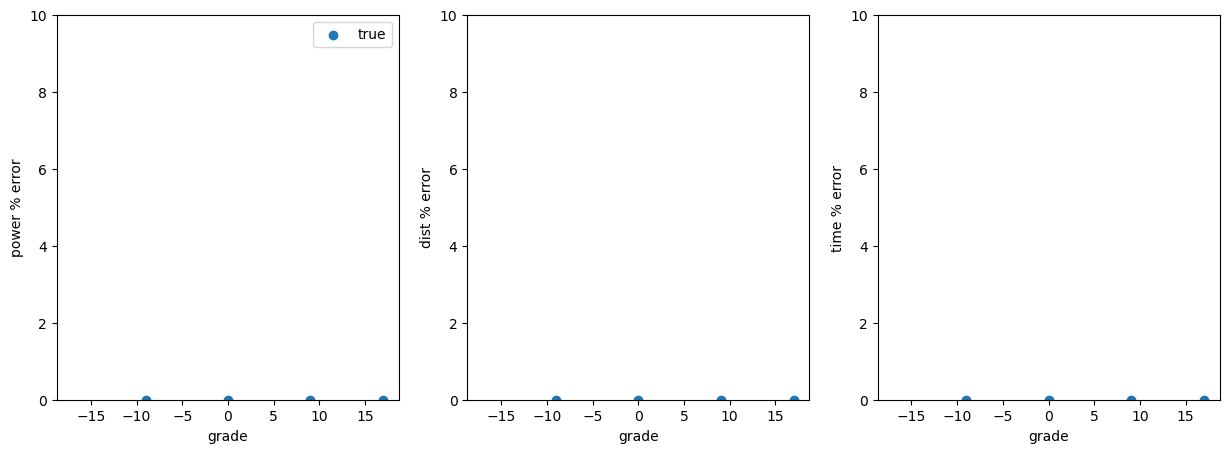

In [262]:
# Plot the percent errors. 
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].scatter(x, mass_bf_vel_results['pow_diff']*100)
ax[0].legend(['true', 'current'])
ax[0].set_xlabel('grade')
ax[0].set_ylabel('power % error')
ax[1].scatter(x, mass_bf_vel_results['dist_diff']*100)
ax[1].set_xlabel('grade')
ax[1].set_ylabel('dist % error')
ax[2].scatter(x, mass_bf_vel_results['t_diff']*100)
ax[2].set_xlabel('grade')
ax[2].set_ylabel('time % error')
ax[0].set_ylim(0, 10)
ax[1].set_ylim(0, 10)
ax[2].set_ylim(0, 10)

### Evaluating Efficacy of Acceleration Methods
Here, I go through and create methods for a ground truth for what the acceleration should be doing, as well as then test the current bus method by matter of comparison for a handful of different grades. 

In [23]:

import line_profiler as lprof
profiler = lprof.LineProfiler()



'''
If the bus accelerates:
starting velocity = 0
mass = 13000
external_acceleration = .098 -- flat
acceleration distance = 20 meters
wind acceleration = 0

the bus needs to accelerate by 0.00545 + .098 + 0 to reach the target goal of .00545
and then by 1.133*1.1 + .098 + 0 to reach the next target of 1.133. 
so, what we can take this to mean is a_prof + a_ext + a_wind = a_true.

In other words, the force the bus wants to perform is 70.8 N in the direction of travel, but will need  70.8*1.1 + 1274 + 0

so the true acceleration of the bus at point 1 will be .1, 
                                       point 2 will be 1.3443
                                       point 3 will be 1.435, ad astra.

to get the true power of the bus, we multiply the true acceleration by the mass and corresponding velocity.

Then, we take that and sum them by each point per. 
'''

def generate_power_frame(m, grade, dist):
    a_fric = (.01)*9.81*np.cos(np.arctan(grade/100))
    a_hill = 9.81*np.sin(np.arctan(grade/100))
    acc_prof = BusModel(a_prof).get_accel_profile().copy()
    profile_length = len(acc_prof)
    
    
    acc_prof=acc_prof.rename(columns = {'accel.[m/s^2]':'true_accel'})
    acc_prof['t_i'] = acc_prof['time[s]']
    del(acc_prof['time[s]'])
    acc_prof['t_f'] = acc_prof['t_i'].shift(-1)
    acc_prof['dt'] = (acc_prof['t_f'] - acc_prof['t_i']) 
    del(acc_prof['t_i'])
    del(acc_prof['t_f'])
    acc_prof['vi'] = 0
    acc_prof['power'] = 0
    acc_prof['a_param'] = 0
    trav_dist = 0
    i = 0
    
    # This could be written more efficiently but it works for now. This loop specifically is the drag.
    while (i<profile_length):
        tr_acc = acc_prof['true_accel'][i]
        dt = acc_prof['dt'][i]
        vi = acc_prof['vi'][i]
        wind_acc = .6*8.58*1.2*(vi**2)/(2*m)
        P = get_power(tr_acc,dt,vi,m,a_hill+a_fric+wind_acc,1.1)
        
        if P > 160000:
            tr_acc = get_max_accel(160000, dt, vi, m, a_hill+a_fric+wind_acc, 1.1)
            P = get_power(tr_acc,
              dt,
              vi,
              m,
              a_hill+a_fric+wind_acc,
              1.1)
            
        # set the column varaibles to the adjustments
        vi += tr_acc * dt
        dx = vi*dt
        
        trav_dist += dx

        acc_prof.at[i+1,'vi'] = vi
        acc_prof.at[i, 'true_accel'] = tr_acc
        acc_prof.at[i, 'power']= P
        acc_prof.at[i, 'dt'] = dt
        acc_prof.at[i, 'a_param'] = (a_hill+a_fric+wind_acc)
        i+=1

    acc_prof.drop(acc_prof.tail(2).index,inplace=True)
    return acc_prof   
        
def get_power(a_true, dt, vi, m, a_out, i_factor):
    P = m * (a_out + i_factor * a_true) * ((2 * vi + dt * a_true) / (2))
    return P
                
                
def get_max_accel(pmax, dt, vi, m, a_out, i_factor):
    sub1 = (4*(i_factor*dt)*((2*pmax/m) - 2*a_out*vi) + (-a_out * dt - 2*vi*i_factor)**2)
    num = (sub1)**(1/2) - (a_out * dt) - (2 * vi * i_factor)
    denom = 2 * i_factor * dt
    
    acc = num/denom
    
    if acc < 0:
        acc = -acc
    
    return acc



def accelerate_v5(m, grade, v_i, dist):
    power_frame = generate_power_frame(m, grade, dist)
    power_frame_len = len(power_frame)
    profile_max = list(power_frame['vi'])[-1]
    trimmed_frame = 0
    trav_dist = 0
    p_list = []
    dt_list = []
    cur_v = v_i
    i=0
    while (dist > trav_dist):
        if (cur_v < profile_max):
            v_closest_index = list((power_frame['vi']-cur_v).abs().argsort())[0]
            p = power_frame['power'][v_closest_index]
            dt = power_frame['dt'][v_closest_index]
            a = power_frame['true_accel'][v_closest_index]
            outside_a = power_frame['a_param'][v_closest_index]
            cur_v += dt*a
            dx = cur_v*dt
            # Check if this would go over the distance
            if dx > abs(trav_dist - dist):
                dx = abs(trav_dist - dist)
                cur_v -= a * dt 
                dt = dx * (1.1 * a + outside_a) * m / p
                cur_v += a * dt
            trav_dist += dx
            p_list.append(p)
            dt_list.append(dt)
            
        else:
            p = list(power_frame['power'])[-2]
            dt = list(power_frame['dt'])[-2]
            a = list(power_frame['true_accel'])[-1]
            outside_a = (.01)*9.81*np.cos(np.arctan(grade/100)) + 9.81*np.sin(np.arctan(grade/100)) + .6*8.58*1.2*(cur_v**2)/(2*m)
            cur_v += dt*a
            dx = cur_v*dt
            # Check if this would go over the distance
            if dx > abs(trav_dist - dist):
                dx = abs(trav_dist - dist)
                cur_v -= a * dt 
                dt = dx * (1.1 * a + outside_a) * m / p
                cur_v += a * dt
            trav_dist += dx
            p_list.append(p)
            dt_list.append(dt)
        i+=1
    
    pow_ser = pd.Series(p_list)
    tee_ser = pd.Series(dt_list)
    travel_time = tee_ser.sum()


    mean_power = (pow_ser * tee_ser).sum() / travel_time
        
    return mean_power, travel_time, cur_v

Comparing dt and power calculations and final velocity vs actual:



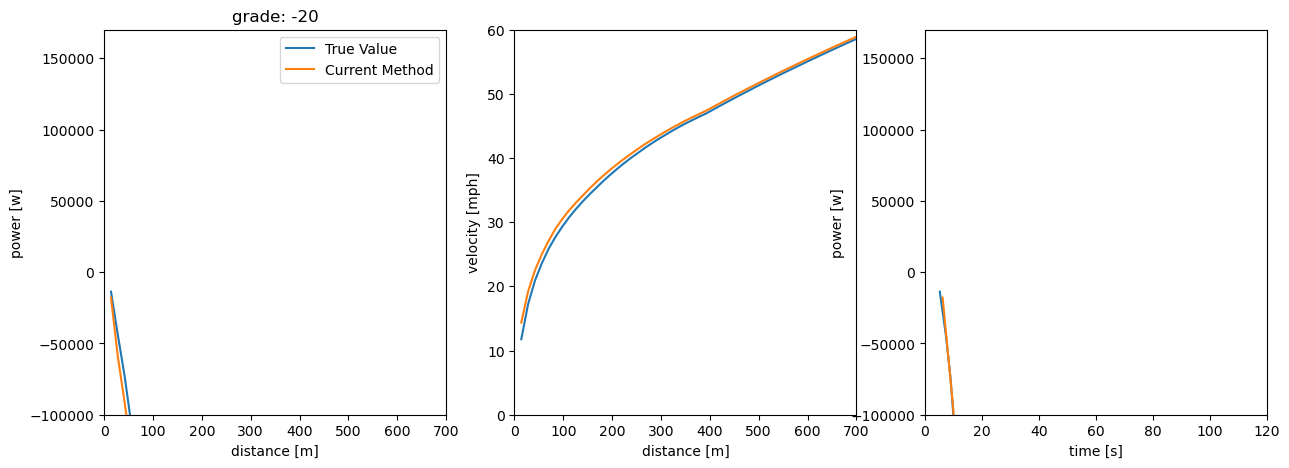

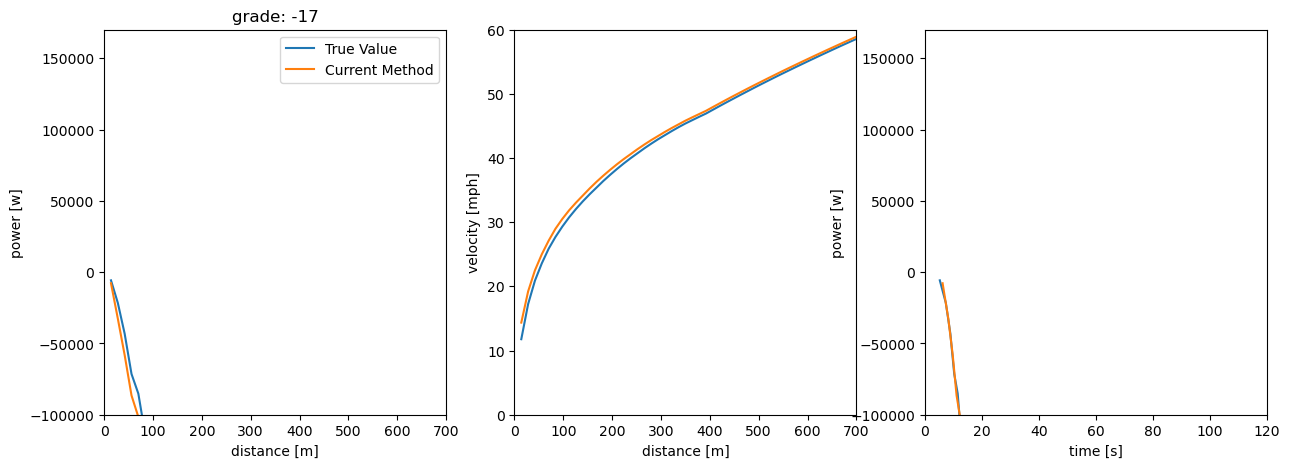

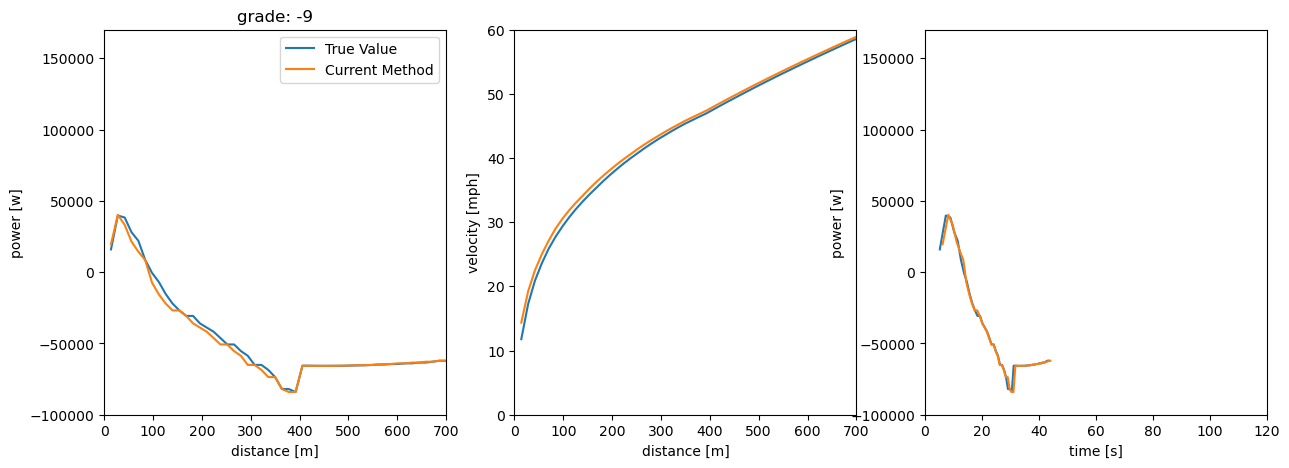

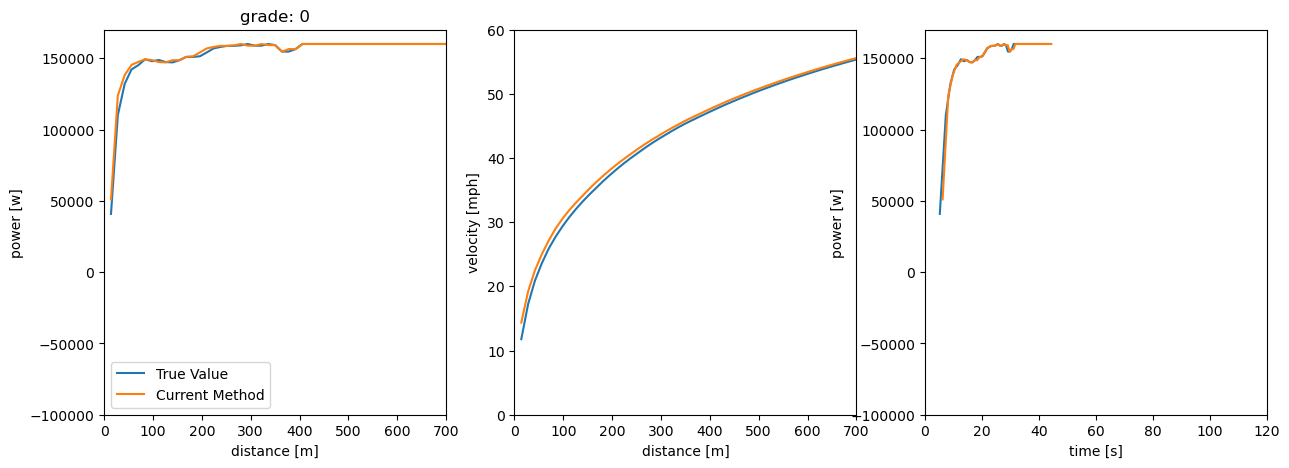

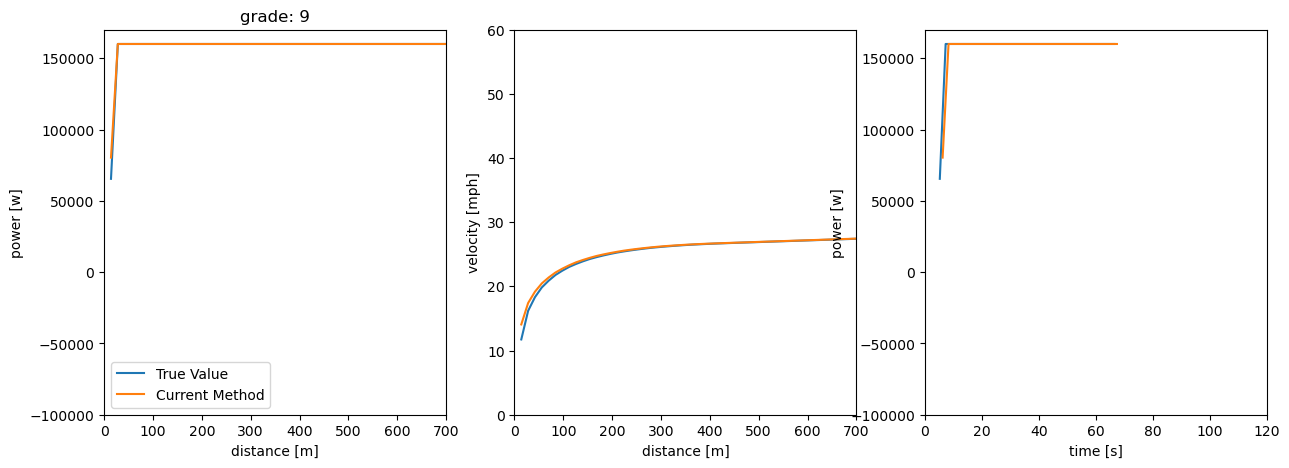

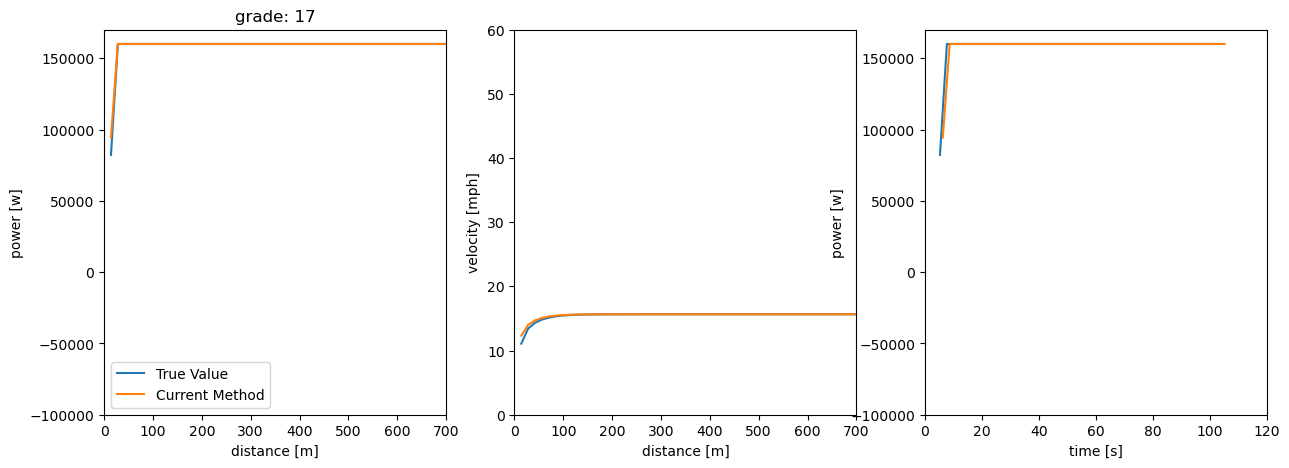

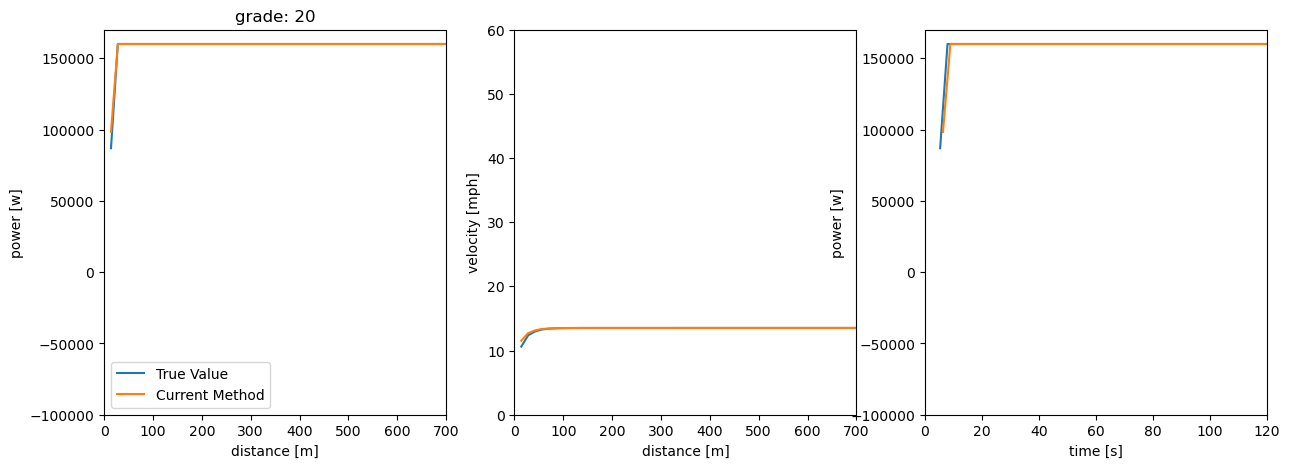

In [68]:
# Here we compare the evaluations for different grades, at a set mass of 13041 kg and an initial velocity of zero.

mass = 13041

# Compare time and power differences between straight-shots and stepwise-----
print("Comparing dt and power calculations and final velocity vs actual:")
print()

for grade in grade_array:
    # unit distance for acceleration is 14 meters
    dist = 14
    
    # initial v is zero
    v = 0
    p_list = []
    t_list = []
    v_list = []
    
    # initial t is zero.
    t_t = 0
    for i in range(50):
        p, t, v = accelerate_v5(mass, grade, v, dist)
        t_t += t
        p_list.append(p)
        t_list.append(t_t)
        v_list.append(v)
        
        
    ext_a = (.01)*9.81*np.cos(np.arctan(grade/100)) + 9.81*np.sin(np.arctan(grade/100))
    sample_bus = BusModel(a_prof)
    p_list_2 = []
    t_list_2 = []
    v_list_2 = []
    t_t = 0
    for i in range(50):
        p, t = sample_bus.accelerate_v5(dist, ext_a)
        t_t += t
        p_list_2.append(p)
        t_list_2.append(t_t)
        v_list_2.append(sample_bus.velocity())
    #print('grade: {}'.format(grade))
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    dist = np.arange(14*1, 14*51, 14)
    ax[0].set_title('grade: {}'.format(grade))
    ax[0].plot(dist, p_list)
    ax[0].plot(dist, p_list_2)
    ax[0].set_xlabel('distance [m]')
    ax[0].set_ylabel('power [w]')
    ax[1].plot(dist, np.asarray(v_list)*2.236)
    ax[1].plot(dist, np.asarray(v_list_2)*2.236)
    ax[1].set_xlabel('distance [m]')
    ax[1].set_ylabel('velocity [mph]')
    ax[2].plot(t_list, p_list)
    ax[2].plot(t_list_2, p_list_2)
    ax[2].set_xlabel('time [s]')
    ax[2].set_ylabel('power [w]')
    ax[0].legend(['True Value','Current Method'])
    ax[0].set_ylim(-100000,170000)
    ax[0].set_xlim(0, 700)
    ax[1].set_ylim(0, 60)
    ax[1].set_xlim(0,700)
    ax[2].set_ylim(-100000,170000)
    ax[2].set_xlim(0, 120)
    
    plt.show()


    

### Evaluating Efficacy of Maintain Method
Here, I compare what the ground truth of maintaining velocity should be, to that of what it is actually being calculated as. 

In [24]:
# Generate the power calculation as it should be
def maintain_power_calc(v_i, m, grade, braking_factor, dist):
    a_fric = (.01)*9.81*np.cos(np.arctan(grade/100))
    a_hill = 9.81*np.sin(np.arctan(grade/100))
    a_wind = .6*8.58*1.2*(v_i**2)/(2*m)
    a_subsum = a_fric + a_hill + a_wind
    bus_a = 0
    # first pass time
    dt = dist/v_i
    a_sum = (bus_a*1.1 +a_subsum)
    v_f = v_i
    # First pass, assuming possible
    power_calc = a_sum * m * v_i
    
    # if the bus exceeds the power limit while matching velocity, it slows down
    if power_calc > 160000:
        
        # if the power calculation is greater than the limit, 
        # find the true acceleration of the bus by solving for dt by adjusting acc.
        while power_calc > 160000:
            bus_a -= 10/160000
            dt = ((2*bus_a*dist + v_i**2)**(1/2) - v_i) / bus_a 
            power_calc = get_power(bus_a, dt, v_i, m, a_subsum, 1.1)
    v_f = v_i + bus_a * dt
    
    return power_calc, dt,  v_f

def bus_maintain(v_i, m, grade, braking_factor, dist):
    sample_bus = BusModel(a_prof, raw_mass = m)
    ext_a = (.01)*9.81*np.cos(np.arctan(grade/100)) + 9.81*np.sin(np.arctan(grade/100))
    sample_bus.set_v(v_i)
    p, t = sample_bus.maintain_v5(dist, ext_a)
    return p, t, sample_bus.velocity()

In [29]:
# Iterate through each parameter and calculate the percent error between each measurement
    
data = []
for mass in mass_array:
    for velocity in velocity_array:
        for grade in grade_array:
            for bf in braking_factors: 
                dist = 14
                dist_bus = 14
                diff = abs(dist_bus-dist) / dist
                bp, bt, v_f =  maintain_power_calc(velocity, mass, grade, bf, dist)
                bup, but, v_f_2 = bus_maintain(velocity, mass, grade, bf, dist_bus)
                dat_dict = {'power_bus': bup,
                            'power_true':bp,
                            'time_bus': but,
                            'time_true':bt,
                            'dist_bus': dist_bus,
                            'dist_true':dist,
                            'dist_diff': diff,
                            'pow_diff': abs(bup-bp)/bp,
                            't_diff':abs(but-bt)/bt,
                            'v_i': velocity,
                            'v_f':v_f,
                            'v_f_bus': v_f_2,
                            'v_f_diff': abs(v_f_2 - v_f)/v_f,
                            'm': mass,
                            'grade':grade,
                            'br_fac':bf}
                
                data.append(dat_dict)
                
# Convert it to a dict.
results = pd.DataFrame(data)

In [30]:
mass_bf_vel_results

,power_bus,power_true,time_bus,time_true,dist_bus,dist_true,dist_diff,pow_diff,t_diff,v_i,v_f,v_f_bus,v_f_diff,m,grade,br_fac
360,-284769.467387,-284769.467387,44.217919,0.700000,884.35837,14,62.168455,-0.000000,62.168455,20,20.000000,20.000000,0.000000,10000,-17,1.0
364,-131617.747921,-131617.747921,10.081547,0.700000,201.63094,14,13.402210,-0.000000,13.402210,20,20.000000,20.000000,0.000000,10000,-9,1.0
368,44330.400000,44330.400000,5.342874,0.700000,106.85747,14,6.632676,0.000000,6.632676,20,20.000000,20.000000,0.000000,10000,0,1.0
372,159997.070853,159999.144354,3.724180,0.703337,72.71133,14,4.193666,0.000013,4.295016,20,19.810231,19.048239,0.038465,10000,9,1.0
376,159990.998808,159994.118274,3.059063,0.712108,56.90910,14,3.064936,0.000019,3.295787,20,19.319893,17.206884,0.109370,10000,17,1.0


Text(0, 0.5, 'dV')

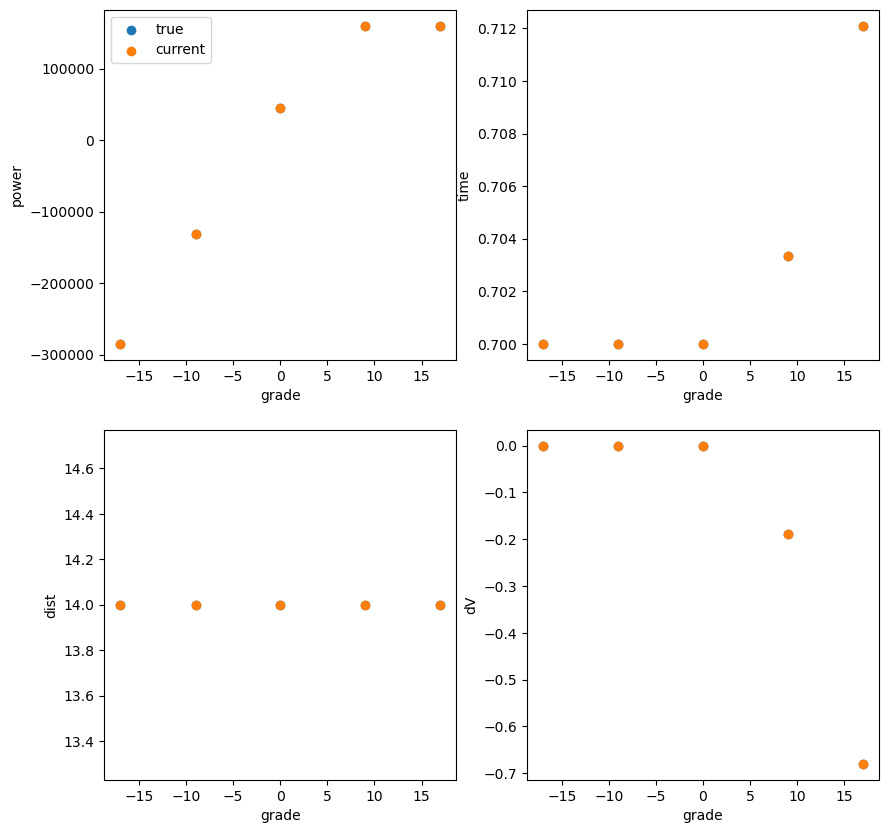

In [33]:
# Plot out the results for the maintaining methods. filter to a set mass, velocity, and braking factor.
mass_evaluation = 10000
velocity_eval = 20
braking_fac = .4
mass_results = (results[results['m'] == mass_evaluation])
mass_vel_results = mass_results[mass_results['v_i'] == velocity_eval]
mass_bf_vel_results = mass_vel_results[mass_vel_results['br_fac'] == braking_fac]

x = mass_bf_vel_results['grade']
y=mass_bf_vel_results['power_true']
y1=mass_bf_vel_results['power_bus']
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax[0, 0].scatter(x, y)
ax[0, 0].scatter(x, y1)
ax[0, 0].legend(['true', 'current'])
ax[0, 0].set_xlabel('grade')
ax[0, 0].set_ylabel('power')
ax[1, 0].scatter(x, mass_bf_vel_results['dist_true'])
ax[1, 0].scatter(x, mass_bf_vel_results['dist_bus'])
ax[1, 0].set_xlabel('grade')
ax[1, 0].set_ylabel('dist')

ax[0, 1].scatter(x, mass_bf_vel_results['time_true'])
ax[0, 1].scatter(x, mass_bf_vel_results['time_bus'])
ax[0, 1].set_xlabel('grade')
ax[0, 1].set_ylabel('time')

ax[1, 1].scatter(x,   mass_bf_vel_results['v_f']- mass_bf_vel_results['v_i'] )
ax[1, 1].scatter(x,   mass_bf_vel_results['v_f_bus']- mass_bf_vel_results['v_i'] )
ax[1, 1].set_xlabel('grade')
ax[1, 1].set_ylabel('dV')



# Note the power discrepancies are due to rounding

Text(0, 0.5, 'time % error')

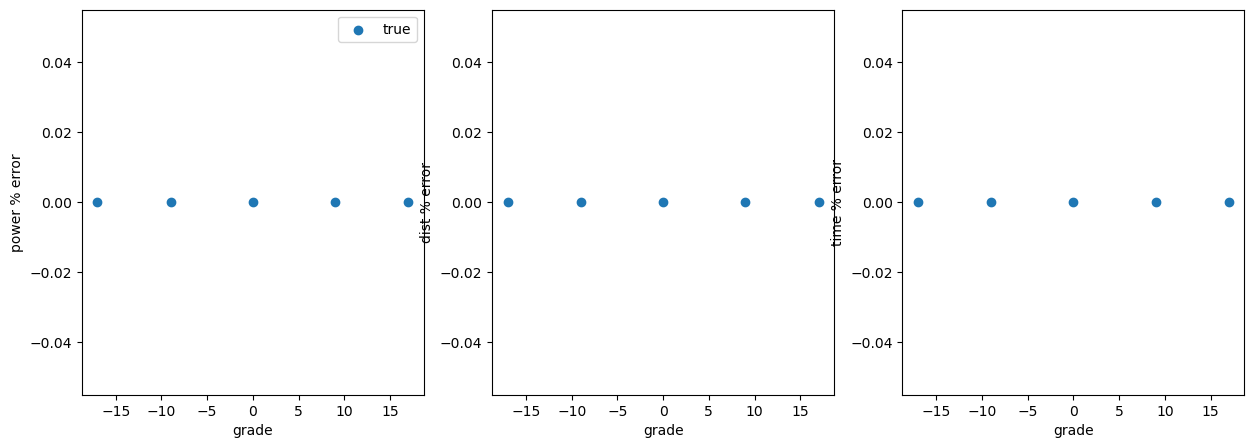

In [32]:
# Plot the percent errors. 
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].scatter(x, mass_bf_vel_results['pow_diff']*100)
ax[0].legend(['true', 'current'])
ax[0].set_xlabel('grade')
ax[0].set_ylabel('power % error')
ax[1].scatter(x, mass_bf_vel_results['dist_diff']*100)
ax[1].set_xlabel('grade')
ax[1].set_ylabel('dist % error')
ax[2].scatter(x, mass_bf_vel_results['t_diff']*100)
ax[2].set_xlabel('grade')
ax[2].set_ylabel('time % error')
# Well, that seems to match pretty darn well. 

### tripdynamics adjustment section

In [302]:
import random
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import RouteMap as rm

class TripDynamics:
    def __init__(self, route_map, bus_model, bus_ridership, braking_aggresion = 1, ridership_type='mean', seed=42, stoplight_chance = .84615):
        self._route_map = route_map
        self._bus_model = bus_model
        self._ridership_type = ridership_type 
        self._rand_seed = seed # life, the universe, and everything
        self._braking_aggression = braking_aggresion # default 1 based on maximum braking aggression
        self._stoplight_chance = stoplight_chance # Defuault based on 120s cycle, 55s g, 65 red/yellow. https://wsdot.wa.gov/travel/operations-services/traffic-signals
        if (self._ridership_type == 'mean'):
            self._ridership = bus_ridership
        elif (self._ridership_type == 'chance'):
            self._ridership = self.riders_from_chance(bus_ridership)
        self._route_data = self._route_map.get_gdf()
        self._route_data['riders'] = self.generate_rider_profile()
        self._route_data['bus_mass'] = self.generate_mass_profile()
        
        self._trip_data = None
        
    
    def generate_rider_profile(self):
        '''
        generate_rider_profile generates a pandas series that contains the
        current amount of riders based on bus position
        
        Parameters:
        None
        
        Returns:
        pandas series matching length of route, with ridership numbers.
        Indicies identical to the route.
        '''
        
        # Copy the ridership changes as d_riders
        d_riders = self._ridership.copy()
        
        # get the series of stop booleans for the route
        stop_bools = self._route_data['is_stop'].copy()
        
        # create a new dataframe based on the stop booleans
        df = pd.DataFrame(stop_bools, columns=['is_stop'])
        
        # default change in riders is 0
        df['d_riders'] = 0
        
        # get a list of indexes on the route that are stops
        stop_indexes = list(df[df['is_stop']==True].index)
        
        # At the stops, add the change in riders
        df.iloc[stop_indexes, df.columns.get_loc('d_riders')] = d_riders
        
        # make the cumulative riders and return it
        df['riders'] = df['d_riders'].cumsum()
        
        # Assign a class variable for ridership change
        self._ridership_change = df['d_riders']
        
        return df['riders']
    
    

    def generate_mass_profile(self):
        '''
        generate_mass_profile generates a pandas series
        containing the total bus mass at each point along
        the trip, based on the ridership information of the route.
        
        Parameters:
        None
        
        Returns:
        a pandas series containing the total bus mass
        at each point on the route, indexed the same.
        '''
        
        # Copy the stops and riders
        stop_bools = self._route_data['is_stop'].copy()
        n_riders = self._route_data['riders'].copy()
        
        # Generate a new dataframe from the stop booleans
        df = pd.DataFrame(stop_bools, columns=['is_stop'])
        
        # Add the default bus mass to the dataframe
        df['total_mass'] = self._bus_model.get_mass()
        
        # add the ridership column to the dataframe
        df['n_riders'] = n_riders
        
        # get stop indexes
        stop_indexes = df[df['is_stop']==True].index
        
        # Get the column indexes of mass and riders
        mass_col_id = df.columns.get_loc('total_mass')
        rider_col_id = df.columns.get_loc('n_riders')
        
        # Loop through each stop,
        for i in range(len(stop_indexes)):
            
            # Get the current route point index
            cur_idx = stop_indexes[i]
            
            # get the ridership value for this index
            rider_val = df.iloc[cur_idx, rider_col_id]
            
            # Set the bus model's riders to the rider value
            self._bus_model.update_riders(rider_val, 'set')
            
            # Get the mass of the bus model
            df.iloc[cur_idx:, mass_col_id] = self._bus_model.get_mass()
        
        # return the total mass series
        return df['total_mass']

    
    def get_mass_profile(self):
        return self._route_data['bus_mass']
    

    def bus_trip(self):
        '''
        bus_trip uses the route data and bus information to simulate the bus
        travelling according to a set logic, and returns the route geodataframe with new information
        on acceleration, time, and velocity.
        '''
        
        # get the route geodataframe
        route = self._route_map.get_gdf()
        
        # get the frictional acceleration profile of the route
        fric_a_prof = self._route_map.get_fric_accel()
        
        # get the hill accelerational profile of the route
        hill_a_prof = self._route_map.get_hill_accel()
        
        # get the bus model
        bus = self._bus_model
        
        # get the friction coefficient of the bus model
        bus_f_coef = bus.get_fric_coeff()
        
        # get the maximum velocity for the defined bus
        max_v = bus.max_velocity()
        
        # variable for how hard the driver presses on the brake while braking
        braking_factor = self._braking_aggression
        
        # define new columns for velocity, stop distance, state, and stopping distance,
        # Power needed, and time change.
        route['vel.[m/s]'] = 0
        route['acc.[m/s^2]'] = 0
        route['stop_dist[m]'] = 0
        route['stppn_dist'] = 0
        route['power_needed[W]'] = 0
        route['st'] = 0
        route['time_change[s]'] = 0
        route['r_change'] = abs(self._ridership_change) > 0
        
        # Generate empty lists to hold the same values as above.
        vel_list = []
        acc_list = []
        dist_list = []
        stp_d_ls = []
        power = []
        st_ls = []
        dt_ls = []
        
        # get the accelerational profile of the bus.
        accel_profile = bus.get_accel_profile()
        
        # Set the random seed
        random.seed(self._rand_seed)
        
        # Set up the final point of the route so that the bus actually stops there.
        route.at[len(route)-2,'is_stop'] = True
        route.at[len(route)-2, 'r_change'] = True
        
        # Loop through each point on the route
        for i in range(1, len(route)-1):
            
            # update the bus's mass.
            current_mass = self._route_data['bus_mass'][i]
            bus.update_mass(current_mass)
            
            # get the current point distance in meters
            point_dist = route['point_distances[km]'][i]*1000 # convert to meters
            
            # get the cumulative distance travelled to this point in meters
            cum_dist = route['cumulative_distance[km]'][i]*1000 # convert to meters
            
            # get the cumulative distance column id
            cum_dist_col_id = route.columns.get_loc('cumulative_distance[km]')
            
            # get the dataframe containing the remaining points that have not been visited
            remaining_trip = route.iloc[i:]
            
            # set the distance to the stop to a dummy variable of 0
            dist_to_stop = 0
            
            # set the index of the next stop to dummy variable of 0
            next_stop_index = 0
            
            # Set up a boolean for checking if the bus will stop. range based on closest integer to the inverse fraction provided
            is_stopping = (random.randrange(int(round(1/self._stoplight_chance),0)) == 0)
            
            # get the list of stops as defined by the distance between each stop on the route,
            #including signals, in meters
            #                                    Check if it's a stop and that stop has a ridership change         or      check if its a signal and the bus is stopping
            stops_remain = remaining_trip[((remaining_trip['is_stop'] == True) & remaining_trip['r_change'] == True)| ((remaining_trip['is_signal'] == True) & is_stopping)]['cumulative_distance[km]'].reset_index(drop=True)*1000 #convert to meters

            # if there are remaining stops,
            if (len(stops_remain) != 0):
                
                # set the distance to the stop to be the difference between the stop distance
                # and cumulative distance
                dist_to_stop = stops_remain[0]-cum_dist # meters
                
                # set the next stop index, handle errors where for some reason there is no value for cumulative distance.
                next_stop_match = route['cumulative_distance[km]'][route['cumulative_distance[km]'] == stops_remain[0]/1000]
                if (len(next_stop_match) != 0):
                    next_stop_index = route['cumulative_distance[km]'][route['cumulative_distance[km]'] == stops_remain[0]/1000].index[0]
                else:
                    # if there's nothing, assume the next stop index is in the next 10.
                    next_stop_index = i+10
                
            # get the current velocity of the bus
            start_velocity = bus.velocity()  
            
            # get the acceleration of bus friction at the point
            a_fric = fric_a_prof[i]*bus_f_coef
            
            # get the acceleration due to gravity at the point
            a_hill = hill_a_prof[i]
            
            # combine the accelerations to get external (to the bus's motor) acceleration
            ext_a = a_fric + a_hill 
            
            # calculate the stopping distance based on the starting velocity and external acceleration
            stopping_dist = bus.get_braking_distance(start_velocity, braking_factor, ext_a) #meters
            
            # get the speed limit at current point
            point_sp_lim = route['speed_limit[km/s]'][i] * 1000 # meters
            
            # Error correction for when speed limit has noise
            stable_limit = True
            if (i > 2 and i < len(route)-2):
                # get a boolean for if any change in speed limit is stable:
                mean_limit = (route['speed_limit[km/s]'][i-1:i+1]*1000).mean()
                stable_limit = abs(point_sp_lim - mean_limit) < .1
                point_sp_lim = mean_limit
            
            # set up a variable for status
            status = ""
            d_power = 0
            d_t = 0
            
            # Driving logic: -------------------------------------------------------
            #If at rest, accelerate for the distance between this and the next point
            if (start_velocity < 0.1):
                status = "accel_from_0"
                d_power, d_t = bus.accelerate_v5(point_dist, ext_a)
                
            # If the distance difference between stopping distance and distance to the stop
            # is less than half the point distance resolution, then brake
            
            elif ((dist_to_stop < (stopping_dist + point_dist))): #and (abs(self._ridership_change[next_stop_index]) > 0)):
                status = "Stopping_brake"
                d_power, d_t = bus.brake_v3(point_dist, braking_factor, ext_a)
            #elif((dist_to_stop-stopping_dist)<= point_dist):
                
            # If the starting velocity is less than the speed limit, accelerate. Margin is 1/25th of speed limit.
            elif(start_velocity < (point_sp_lim - point_sp_lim/25)):
                status = "speed_lim_accel"
                d_power, d_t = bus.accelerate_v5(point_dist, ext_a)
                
            # if the starting celocity is greater than the speed limit, 
            elif(start_velocity > (point_sp_lim+point_sp_lim/25)):
                status = "speed_lim_brk"
                
                # brake for that distance
                d_power, d_t = bus.brake_v3(point_dist, braking_factor-.4, ext_a)
            else:
                status = "maintain_v"
                d_power, d_t = bus.maintain_v5(point_dist, ext_a)
            # End driving logic ---------------------------------------------------------
            
            
            # Append all the statuses and data to their lists
            st_ls.append(status)
            vel_list.append(bus.velocity())
            acc_list.append(bus.get_acceleration())
            dist_list.append(dist_to_stop)
            stp_d_ls.append(stopping_dist)
            power.append(d_power)
            dt_ls.append(d_t)
        
        # convert the lists and apply them to the respective columns
        route.iloc[1:-1, route.columns.get_loc('vel.[m/s]')] = vel_list
        route.iloc[1:-1, route.columns.get_loc('acc.[m/s^2]')] = acc_list
        route.iloc[1:-1, route.columns.get_loc('stop_dist[m]')] = dist_list
        route.iloc[1:-1, route.columns.get_loc('stppn_dist')] = stp_d_ls
        route.iloc[1:-1, route.columns.get_loc('power_needed[W]')] = power
        route.iloc[1:-1, route.columns.get_loc('st')] = st_ls
        route.iloc[1:-1, route.columns.get_loc('time_change[s]')] = dt_ls
        
        route['elapsed_time[s]'] = route['time_change[s]'].cumsum()
        
        # Set the route GDF to an instance variable, then return it.
        self._trip_data = route
        return route
    
    
    def get_all_data(self):
        '''
        get_all_data returns the dataframe generated after a trip is performed.
        Parameters:
        N/A
        Returns: 
        Dataframe of Trip data, or None if no trip has been performed.
        '''
        if (self._trip_data is None):
            print("Warning, bus_trip() method has not yet been used!")
        return self._trip_data
      
        
    def generate_ESS_profile(self):
        '''
        generate_ESS_profile() is a method to create the Energy Storage System
        power profile based on the required power. Note: This requires bus_trip()
        to be run prior.
        
        Parameters:
        N/A
        
        Returns:
        Pandas series containing required power from the ESS.
        '''
        # Get the trip data's power requirements
        power_profile = self.get_all_data()['power_needed[W]']
        
        # Apply the instance power method to the power profile.
        ESS_profile = power_profile.apply(self.calc_instance_power)
        
        # Return the profile.
        return ESS_profile
    
    
    def calc_instance_power(self, value):
        '''
        calc_instance_power takes in a power value,
        and converts it to the corresponding load on the ESS.
        
        Parameters:
        value: a power value in Watts, as an int or float.
        
        Returns:
        converted battery power as a float.
        '''
        # Get the bus model parameters.
        motor_eff = self._bus_model.get_motor_eff()
        invert_eff = self._bus_model.get_invert_eff()
        aux_eff = self._bus_model.get_auxill_efficiency()
        aux_load = self._bus_model.get_aux_load()
        regen_eff = self._bus_model.get_regen_eff()
        max_regen = -100000
        
        # set the battery power to zero.
        bat_pow = 0
        
        # Including Auxilliary load, though not strictly important at the moment. 
        if (value >= 0):
            # Discharging, converting the needed power into power battery must exert
            bat_pow = value/(motor_eff*invert_eff) + (aux_load/aux_eff)
        elif(value*regen_eff*motor_eff > max_regen):
            #charging, the regenerative braking ALL the time, max regen is 100
            bat_pow = value*regen_eff*motor_eff + (aux_load/aux_eff)
        else:
            bat_pow = max_regen + (aux_load/aux_eff)
            
            
        # Return the battery power.
        return bat_pow
    
    
    def export_trip_data(self):
        '''
        export_trip_data generates a geodataframe with the most relevant informaton for
        ease of use and understanding. For a hollistic report, get_all_data is better suited.
        
        Parameters:
        N/A
        
        Returns:
        geodataframe containing trip geometry, elevation, distance, grade, ridership, mass, velocity,
        elapsed time, and power needed in Watts. 
        '''
        # Drop non-relevant columns.
        raw_trip_data = self.get_all_data().copy()
        raw_trip_data.drop("stop_dist[m]", axis='columns', inplace=True)
        raw_trip_data.drop("stppn_dist", axis='columns', inplace=True)
        raw_trip_data.drop("power_needed[W]", axis='columns', inplace=True)
        raw_trip_data.drop("is_stop", axis='columns', inplace=True)
        raw_trip_data.drop("is_signal", axis='columns', inplace=True)
        raw_trip_data.drop("point_distances[km]", axis='columns', inplace=True)
        raw_trip_data.drop("latitude", axis='columns', inplace=True)
        raw_trip_data.drop("longitude", axis='columns', inplace=True)
        raw_trip_data.drop("speed_limit[km/s]", axis='columns', inplace=True)
        
        # Add the ESS profile.
        raw_trip_data['power_needed[W]'] = self.generate_ESS_profile()
        
        # return the trip data.
        return raw_trip_data

### Route Efficacy Testing:

In [301]:
# Load the csv of the rider difference
# sorted_riders_diff = (pd.read_csv('rider_diff_22.csv', index_col=False, header=0))['0']
default_bus = BusModel(a_prof)
# generate a tripDynamics object, using the route map, bus, and ridership
# changes
pd.set_option('display.max_rows', None)
test_trip_dynamic = TripDynamics(smoothed_test_map,
                                    default_bus,
                                    sorted_riders_diff)

# Run the trip
test_trip = test_trip_dynamic.bus_trip()

In [293]:
test_trip[(test_trip['cumulative_distance[km]']> 2.9) & (test_trip['cumulative_distance[km]']< 3)]
#test_trip[test_trip.index > 1590]

,Unnamed: 0,geometry,elevation[km],latitude,longitude,point_distances[km],cumulative_distance[km],speed_limit[km/s],is_stop,is_signal,vel.[m/s],acc.[m/s^2],stop_dist[m],stppn_dist,power_needed[W],st,time_change[s],inertial_force,r_change,elapsed_time[s]
198,198,POINT (-122.38731 47.53591),0.1,-122.387312,47.535913,0.014849,2.911674,0.026822,False,False,25.882334,0,4268.117953,175.75177,86869.974799,maintain_v,0.573725,0,False,208.947606
199,199,POINT (-122.38731 47.53577),0.1,-122.387314,47.535767,0.014849,2.926523,0.011176,False,False,25.157436,0,4253.268607,175.75177,-331497.947518,speed_lim_brk,0.581874,0,False,209.529479
200,200,POINT (-122.38732 47.53562),0.1,-122.387315,47.535621,0.014849,2.941372,0.011176,True,False,24.416319,0,4238.419257,166.80726,-321976.336751,speed_lim_brk,0.599081,0,False,210.128560
201,201,POINT (-122.38732 47.53547),0.1,-122.387317,47.535475,0.014849,2.956222,0.011176,False,False,23.657421,0,4223.569903,157.84363,-312233.892622,speed_lim_brk,0.617774,0,False,210.746334
202,202,POINT (-122.38732 47.53533),0.1,-122.387319,47.535329,0.014849,2.971071,0.011176,True,False,22.878932,0,4208.720547,148.86106,-302248.721261,speed_lim_brk,0.638183,0,False,211.384517
203,203,POINT (-122.38732 47.53518),0.1,-122.387320,47.535183,0.014849,2.985920,0.011176,False,False,22.078740,0,4193.871190,139.85969,-291995.355923,speed_lim_brk,0.660593,0,False,212.045110


In [ ]:
# plot the ESS load:
# get the ESS profile of the trip:
ess_prof = test_trip_dynamic.generate_ESS_profile()

# Convert the ess profile to kilowatts:
ess_prof = ess_prof/1000

raw_prof = test_trip['power_needed[W]']/1000

# get the distance series:
distance = test_trip['cumulative_distance[km]']

# get the elevation series:
elev = test_trip['elevation[km]']

# get the time change series:
delta_tees = test_trip['time_change[s]']

# get running time series
time = test_trip['elapsed_time[s]']

# convert time change to minutes
delta_tees = delta_tees/60
time = time/60

# generate figure
fig, ax = plt.subplots(3, 1, figsize = (12, 15), dpi=300)
plt.tight_layout()



# Load profile (distance based)
#ax[0].plot(distance, test_trip['vel.[m/s]']*2.236, c='#b319b3')
#ax[0].plot(distance, test_trip["vel.[m/s]"], c='yellow')
#ax[0].plot(distance, ess_prof, c='#b319b3')
ax[0].set_xlabel("Distance [km]")
ax[0].set_ylabel("Battery Power [kW]")
#ax[0].set_ylabel("Velocity [m/s]")
ax[0].set_zorder(1)
ax[0].set_facecolor('none')
ax[0].grid(axis='y')
#ax[0].set_xlim(2.9, 3)
#ax[0].set_xlim(37.5,40)
#ax[0].set_xlim(23.68, 24)
#ax[0].set_xlim(7,8)
#ax[0].set_ylim(0, 15)
ax[0].plot(distance, test_trip["vel.[m/s]"], c='#b319b3')
ax[0].plot(distance, test_trip['speed_limit[km/s]']*1000)
ax[0].plot(distance, test_trip['speed_limit[km/s]']*1000 + test_trip['speed_limit[km/s]']*1000/25, c='tab:orange')
ax[0].plot(distance, test_trip['speed_limit[km/s]']*1000 - test_trip['speed_limit[km/s]']*1000/25, c='tab:orange')

# Elevation
ax_0_1 = ax[0].twinx()
ax_0_1.fill_between(distance, elev, color = '#BDBDBD')
ax_0_1.set_ylabel("Elevation [km]")
ax_0_1.set_zorder(0)

ax_0_1.scatter(distance, test_trip['is_stop']*elev, c="tab:green")
ax_0_1.scatter(distance, test_trip['is_signal']*elev, c="tab:red")

# Load profile (time based)
ax[1].plot(time, ess_prof, c='#b319b3')
ax[1].set_xlabel("Time [min]")
ax[1].set_ylabel("Battery Power [kW]")
ax[1].set_zorder(1)
ax[1].set_facecolor('none')
ax[1].grid(axis='y')

# Elevation
ax_1_1 = ax[1].twinx()
ax_1_1.fill_between(time, elev, color = '#BDBDBD')
ax_1_1.set_ylabel("Elevation [km]")
ax_1_1.set_zorder(0)


# Power Bin Histogram
bins = [-140,-120,-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]
ax[2].hist(ess_prof, color='#b319b3', bins=bins, weights=delta_tees)
ax[2].set_ylabel('Time[min]')
ax[2].set_xlabel('Load [kW]')
ax[2].tick_params(labelsize=12)
ax[2].set_xticks(bins)
ax[2].grid(axis='y')

# Create a column for the ess profile
dts = test_trip['time_change[s]']
net_energy = (ess_prof*dts).sum()/3600 # kWh
print("Total Energy Used: {} kWh".format(net_energy))
print("Heuristic: {} mi/kwh".format(list(test_trip['cumulative_distance[km]'])[-2]*0.6213712 / net_energy))
# control drag coefficient
# Control road drag
# plot each term, what value
# Elevation
# ffc of the parameters for the bus to deduce which is the issue
# reduce passenger mass/INCREASE mass

# Is there a straight line where this happens?
# is it wiggling in slope causing instability?
# look at linear stability theory

# different slopes, different enveopes of distance and uncertainty, plot stable, unstable and find stable and unstable
# damping factor via forward differencing, remove oscillation

# Standard EV on ld veh. 4mi p kwh
# Big tesla 3, small american 4, mitsubishi 6.25

# gut check should be kwh/mi

# Elevation from google API?


# plot estimated power/velocity vs true power and velocity


NameError: name 'test_trip_dynamic' is not defined

mean load: 25.189797622445276
    stdev: 76.87801683066795


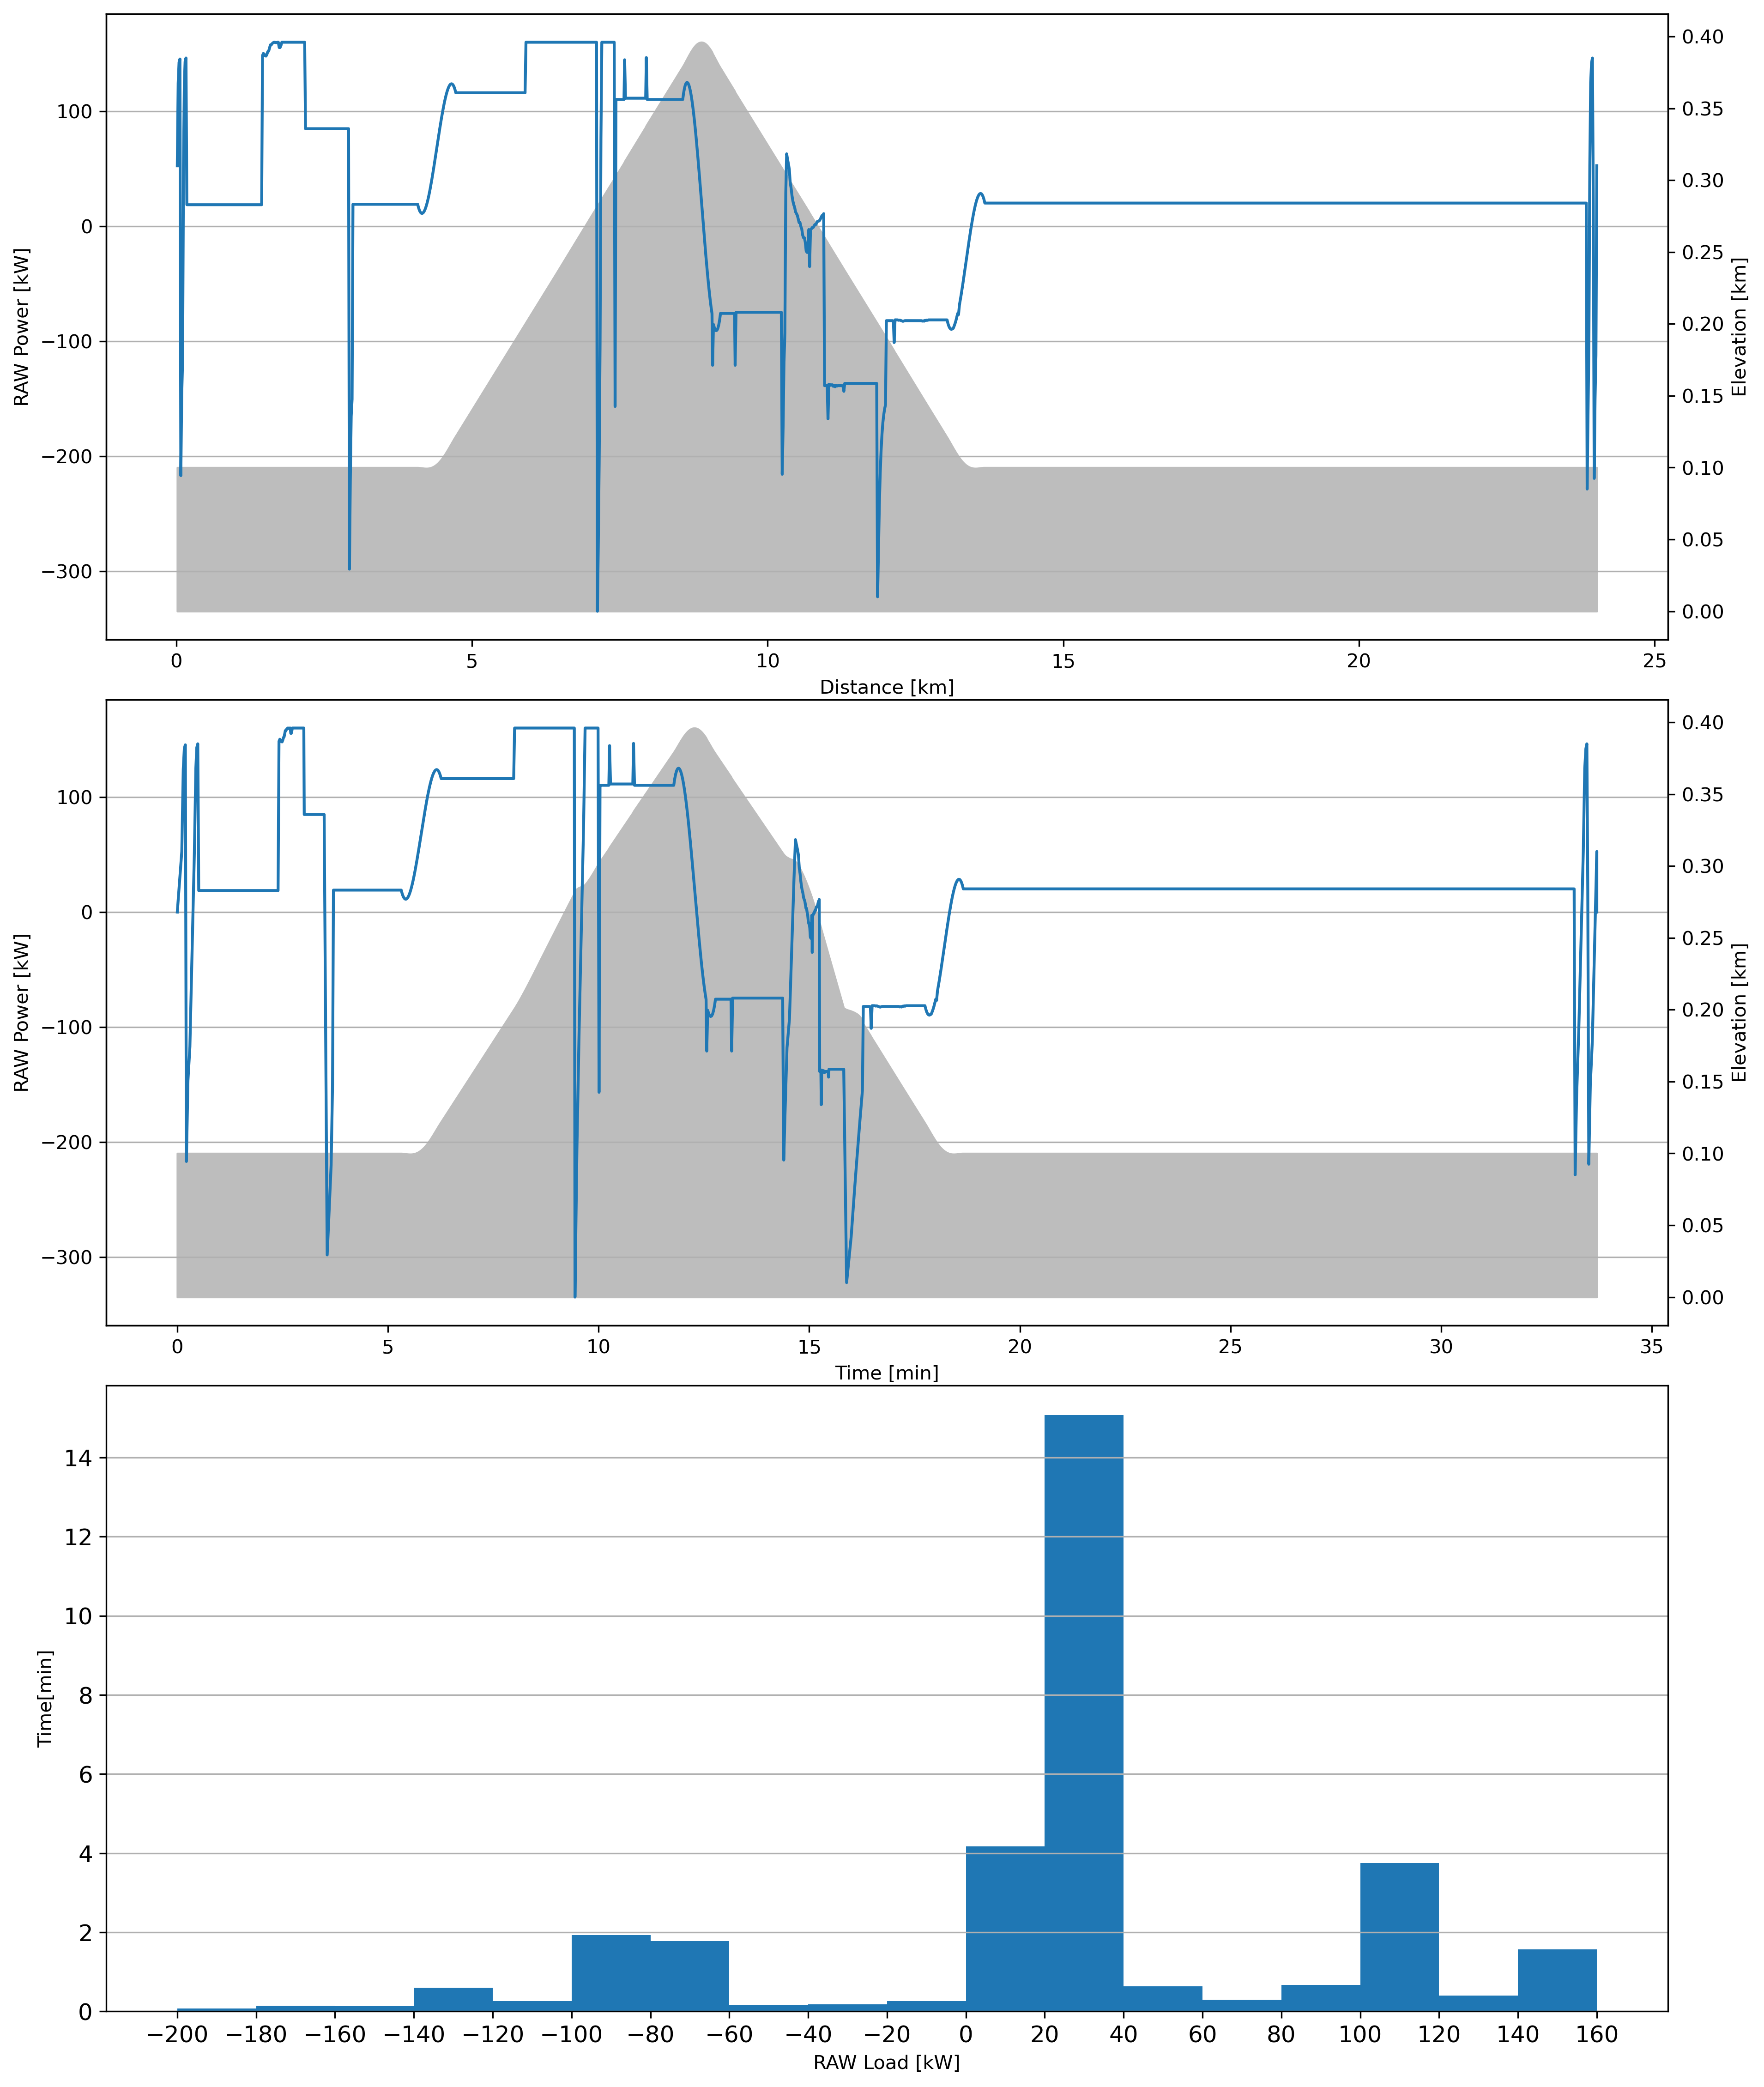

In [268]:
# Plot the raw load

# Time in hours * each bin BC we want to know kwH, 
# generate figure
fig, ax = plt.subplots(3, 1, figsize = (12, 15), dpi=300)
plt.tight_layout()

# Load profile (distance based)
ax[0].plot(distance, raw_prof, c='tab:blue')
ax[0].set_xlabel("Distance [km]")
ax[0].set_ylabel("RAW Power [kW]")
ax[0].set_zorder(1)
ax[0].set_facecolor('none')
ax[0].grid(axis='y')


# Elevation
ax_0_1 = ax[0].twinx()
ax_0_1.fill_between(distance, elev, color = '#BDBDBD')
ax_0_1.set_ylabel("Elevation [km]")
ax_0_1.set_zorder(0)

# Load profile (time based)
ax[1].plot(time, raw_prof, c='tab:blue')
ax[1].set_xlabel("Time [min]")
ax[1].set_ylabel("RAW Power [kW]")
ax[1].set_zorder(1)
ax[1].set_facecolor('none')
ax[1].grid(axis='y')

# Elevation
ax_1_1 = ax[1].twinx()
ax_1_1.fill_between(time, elev, color = '#BDBDBD')
ax_1_1.set_ylabel("Elevation [km]")
ax_1_1.set_zorder(0)


# Power Bin Histogram
bins = [-200,-180,-160,-140,-120,-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160]
ax[2].hist(raw_prof, color='tab:blue', bins=bins, weights=delta_tees)
ax[2].set_ylabel('Time[min]')
ax[2].set_xlabel('RAW Load [kW]')
ax[2].tick_params(labelsize=12)
ax[2].set_xticks(bins)
ax[2].grid(axis='y')

print('mean load: {}'.format(raw_prof.mean()))
print('    stdev: {}'.format(raw_prof.std()))